# 1. Set-Up

In [49]:
import json
import pandas as pd

In [50]:
# Load the JSON data (replace with your actual file paths)
with open('C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/9 term/raw data/national party included/9term_apas_w_nationalParty_noMANUAL.json', 'r', encoding='utf-8') as f1, open('C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/10 term/raw data/national party, 10-11-2024/mep_assistants_national_party.json', 'r', encoding='utf-8') as f2:
    term9 = json.load(f1)
    term10 = json.load(f2)

def clean_invalid_meps(json_data):
    """
    This function filters out MEP entries with missing 'group', 'national_party', or 'country'.
    It returns the cleaned list of MEPs and also tracks the MEPs with missing fields.
    """
    cleaned_json_data = []
    invalid_meps = []

    # Iterate through the JSON data
    for entry in json_data:
        name = entry.get('name')
        group = entry.get('group')
        national_party = entry.get('national_party')
        country = entry.get('country')

        # If any critical field is missing, add to invalid_meps and skip this MEP
        if not group or not national_party or not country:
            invalid_meps.append({
                'name': name,
                'group_missing': not group,
                'national_party_missing': not national_party,
                'country_missing': not country
            })
            continue  # Skip this MEP and do not add it to cleaned_json_data

        # Add to cleaned data if no fields are missing
        cleaned_json_data.append(entry)

    return cleaned_json_data, invalid_meps

term9_cleaned, invalid_meps = clean_invalid_meps(term9)

convert to data frame

In [51]:
# Convert data to DataFrame
df_9th = pd.json_normalize(term9_cleaned)
df_9th['term'] = 9  # Add term info
df_10th = pd.json_normalize(term10)
df_10th['term'] = 10


all_meps = pd.concat([df_9th, df_10th], ignore_index=True)
print(all_meps.columns)

Index(['name', 'group', 'country', 'national_party',
       'assistants.Accredited assistants', 'assistants.Local assistants',
       'assistants.Service providers', 'assistants.Paying agents',
       'assistants.Accredited assistants (grouping)',
       'assistants.Assistants to the Vice-Presidency/to the Quaestorate',
       'term', 'mep_group', 'mep_national_party',
       'assistants.Assistants to the Quaestorate',
       'assistants.Local assistants (grouping)',
       'assistants.Paying agents (grouping)', 'assistants.Trainees',
       'assistants.Assistants to the Vice-Presidency'],
      dtype='object')


# 2. Standardize & Transform

In [52]:
# Merge 'mep_group' and 'group'
all_meps['group'] = all_meps['mep_group'].combine_first(all_meps['group'])

# Merge 'mep_national_party' and 'national_party'
all_meps['national_party'] = all_meps['mep_national_party'].combine_first(all_meps['national_party'])

# Drop the redundant columns after merging
all_meps.drop(columns=['mep_group', 'mep_national_party'], inplace=True)

# Check the updated DataFrame
print(all_meps.tail())

print(all_meps['term'].unique())

                            name  \
1408           Nicola ZINGARETTI   
1409             Kosma ZŁOTOWSKI   
1410  Juan Ignacio ZOIDO ÁLVAREZ   
1411               Željana ZOVKO   
1412                  Milan ZVER   

                                                  group   country  \
1408  Group of the Progressive Alliance of Socialist...     Italy   
1409        European Conservatives and Reformists Group    Poland   
1410  Group of the European People's Party (Christia...     Spain   
1411  Group of the European People's Party (Christia...   Croatia   
1412  Group of the European People's Party (Christia...  Slovenia   

                      national_party  \
1408             Partito Democratico   
1409          Prawo i Sprawiedliwość   
1410                 Partido Popular   
1411  Hrvatska demokratska zajednica   
1412   Slovenska demokratska stranka   

                       assistants.Accredited assistants  \
1408  [Giovanni CRISANTI, SARA GJINI, Galileo Lorenz...   
1409    [

In [53]:
# keep only columns that we will use in analysis
columns_to_keep = [
    'name',
    'national_party', 
    'group', 
    'country', 
    'term', 
    'assistants.Accredited assistants', 
    'assistants.Accredited assistants (grouping)'
]

# filter the DataFrame
meps_apas = all_meps[columns_to_keep]

# rename the columns by removing the 'assistants.' prefix
meps_apas.columns = [col.replace('assistants.', '') for col in meps_apas.columns]

print(meps_apas.columns)

Index(['name', 'national_party', 'group', 'country', 'term',
       'Accredited assistants', 'Accredited assistants (grouping)'],
      dtype='object')


In [54]:
# Create a mapping dictionary for party names to abbreviations
group_abbreviations = {
    'Renew Europe Group': 'Renew',
    'European Conservatives and Reformists Group': 'ECR',
    "Group of the European People's Party (Christian Democrats)": 'EPP',
    'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament': 'S&D',
    'Identity and Democracy Group': 'ID',
    'Group of the Greens/European Free Alliance': 'G/EFA',
    'Confederal Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Non-attached Members': 'NI',
    'The Left group in the European Parliament - GUE/NGL': 'GUE/NGL',
    'Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Patriots for Europe Group': 'Patriots',
    'Europe of Sovereign Nations Group': 'ESN'
}

meps_apas.loc[:, 'group_abbr'] = meps_apas['group'].map(group_abbreviations)
#print(meps_apas['national_party'].unique())
print(meps_apas['group_abbr'].unique())
# #print(meps_apas.columns)

# Iterate through the rows of the DataFrame
for index, row in meps_apas.iterrows():
    if pd.isna(row['group_abbr']):
        print(row['name'])

['Renew' 'ECR' 'EPP' 'S&D' 'ID' 'G/EFA' 'GUE/NGL' 'NI' 'ESN' 'Patriots']


C:\Users\Emilia\AppData\Local\Temp\ipykernel_25844\3012400087.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meps_apas.loc[:, 'group_abbr'] = meps_apas['group'].map(group_abbreviations)


In [55]:
# Function to extract relevant assistants with type information
def extract_assistants(row):
    assistants = []
    # Define relevant groups and their corresponding types
    assistant_groups = {
        'Accredited assistants': 'accredited',
        'Accredited assistants (grouping)': 'accredited_grouping'
    }
    
    for group, assistant_type in assistant_groups.items():
        # Check if the group exists in the row and is a list
        if group in row and isinstance(row[group], list):
            for name in row[group]:
                assistants.append({
                    'assistant_name': name,
                    'mep_name': row['name'],
                    'group_full': row['group'],
                    'group_abbr': row['group_abbr'],
                    'mep_party': row['national_party'],
                    'country': row['country'],
                    'term': row['term'],
                    'assistant_type': assistant_type  # Add assistant type
                })
    return assistants

# Flatten assistants for easier comparison
assistant_data = pd.DataFrame(
    [item for sublist in meps_apas.apply(extract_assistants, axis=1) for item in sublist]
)
print(assistant_data)
print(assistant_data['term'].unique())

                         assistant_name         mep_name  \
0                 Anna Sophia BENGTSSON  Abir AL-SAHLANI   
1               John August HULTENGAARD  Abir AL-SAHLANI   
2                  Tyra Louise LUNDBERG  Abir AL-SAHLANI   
3     Linn Christina Brunhilde OETTERLI  Abir AL-SAHLANI   
4               Sylwia Joanna BETKOWSKA     Adam JARUBAS   
...                                 ...              ...   
6711          Andréa Laure Marie MOULIN    Željana ZOVKO   
6712                         Polona KEK       Milan ZVER   
6713                     Petra SKRINJAR       Milan ZVER   
6714                        Peter SUHEL       Milan ZVER   
6715                     Dominik STRAKL       Milan ZVER   

                                             group_full group_abbr  \
0                                    Renew Europe Group      Renew   
1                                    Renew Europe Group      Renew   
2                                    Renew Europe Group      Renew   

In [56]:
# FIRST REMAP THE NAMES
from fuzzywuzzy import fuzz

def find_similar_names(df, same_term=True):
    similar_pairs = []

    # Iterate through each MEP
    for mep in df['mep_name'].unique():
        # Filter for the current MEP
        if same_term:
            mep_data = df[df['mep_name'] == mep]
        else:
            mep_data = df[df['mep_name'] == mep]  # No term filter for this case

        # Check if the DataFrame contains 'term' column
        term = mep_data['term'].iloc[0] if 'term' in mep_data.columns else "Unknown term"

        names = mep_data['assistant_name'].tolist()

        # Check for similarity between each pair of assistant names
        for i in range(len(names)):
            for j in range(i + 1, len(names)):
                # Calculate similarity score
                score = fuzz.ratio(names[i].lower(), names[j].lower())
                
                # Adjusting the threshold between 90 and 99
                if 75 <= score < 100:  # Use the desired range here
                    similar_pairs.append((names[i], names[j], mep, term))

    return similar_pairs

# Find similar names considering only the same term
#similar_names_same_term = find_similar_names(assistant_data, same_term=True)
#print("Similar assistant names for the same MEP in the same term:")
#for name1, name2, mep in similar_names_same_term:
#    print(f"{name1} and {name2} for {mep} are similar.")

# create remapping based on similar names
name_mapping = {
    "Magdalena NOWACKA": "Magdalena HILLS-NOWACKA", 
    "PAULA SENDIN RODRIGUEZ": "Paula SENDÍN RODRIGUEZ",
    "Eleonora Nikolaycheva GUIGOVA": "Eleonora Nikolaycheva GUIGOVA-NOSKER",
    "Eleonora Nikolaycheva GUIGOVA-NOSKER": "Eleonora Nikolaycheva GUIGOVA-NOSKER",
    "Stefanie SIFFT": "Stefanie SIFFT",
    "Stefanie Gabi SIFFT": "Stefanie SIFFT",
    "Anne-Cecile Juliette GAULT": "Anne-Cecile Juliette GAULT",
    "Anne-Cecile Juliette Rachel GAULT": "Anne-Cecile Juliette GAULT",
    "Sophie Anne Geraldine Marie GUIL": "Sophie Anne Geraldine Marie GUIL",
    "Sophie Anne Geraldine Marie Genevieve GUIL": "Sophie Anne Geraldine Marie GUIL",
    "Ana LOPEZ GONZALEZ": "ANA LÓPEZ GONZÁLEZ",
    "ANA LÓPEZ GONZÁLEZ": "ANA LÓPEZ GONZÁLEZ",
    "Claudia MARTINEZ MUNOZ": "Claudia MARTÍNEZ MUÑOZ",
    "CLAUDIA MARTÍNEZ MUÑOZ": "Claudia MARTÍNEZ MUÑOZ",
    "Maria Mercedes GARCIA MUNOZ": "MARIA MERCEDES GARCIA MUÑOZ",
    "MARIA MERCEDES GARCIA MUÑOZ": "MARIA MERCEDES GARCIA MUÑOZ",
    "Gilles Willy B SEGERS": "GILLES WILLY SEGERS",
    "GILLES WILLY SEGERS": "GILLES WILLY SEGERS",
    "Magdalena GONZALEZ GOZALBO": "Maria Magdalena GONZALEZ GOZALBO",
    "Maria Magdalena GONZALEZ GOZALBO": "Maria Magdalena GONZALEZ GOZALBO",
    "Arturo VILLARROYA GONZALEZ": "Arturo VILLARROYA GONZÁLEZ",
    "Fernando Jose NUNEZ ROBRES PATINO": "Fernando Jose NUNEZ-ROBRES PATINO",
    "Fernando Jose NUNEZ-ROBRES PATINO": "Fernando Jose NUNEZ-ROBRES PATINO",
    "Bibiana CARRETO PEREZ BARBADILLO": "BIBIANA CARRETO PÉREZ BARBADILLO",
    "BIBIANA CARRETO PÉREZ BARBADILLO": "BIBIANA CARRETO PÉREZ BARBADILLO",
    "Magdalena GONZALEZ GOZALBO": "Maria Magdalena GONZALEZ GOZALBO",
    "PAULA SENDIN RODRIGUEZ": "Paula SENDÍN RODRIGUEZ",
    "Paula SENDIN RODRIGUEZ": "Paula SENDÍN RODRIGUEZ",
    "MARIA MERCEDES GARCIA MUNOZ": "MARIA MERCEDES GARCIA MUÑOZ", 
    "ARTURO VILLARROYA GONZALEZ": "Arturo VILLARROYA GONZÁLEZ",
    "ARTURO VILLARROYA GONZALEZ":"Arturo VILLARROYA GONZÁLEZ", 
    "Marlene Elisabeth SEELMAIER": "Marlene Elisabeth STROEHM",          # NAMED CHANGED, CURRENT REMAPPING FOUND IN 10th term 
    "Olivia Jeanna Beatrice ANDERSSON": "Olivia Jeanna Beatrice STÅNGE", # NAMED CHANGED, CURRENT REMAPPING FOUND IN 10th term
    "Sirle ROSENFELDT": "Sirle ROSENFELDT - KOOP",                       # NAMED CHANGED, CURRENT REMAPPING FOUND IN 10th term
    "Saara ANTTINEN": "Saara ANTTINEN-KHUMALO",                          # NAMED CHANGED, CURRENT REMAPPING FOUND IN 10th term
    "Nikolina BRKOVIC": "Nikolina BRKOVIC STANCHEVA", 
    "Josep/Pepe MERCADAL BAQUERO": "Pepe MERCADAL BAQUERO",               # CHANGED HIS NAME TO PEPE
    "Josep MERCADAL BAQUERO": "Pepe MERCADAL BAQUERO" 
}

# remap 
assistant_data['assistant_name'] = assistant_data['assistant_name'].replace(name_mapping)

# check that name remapping worked
# Find similar names considering only the same term
similar_names_same_term = find_similar_names(assistant_data, same_term=True)
print("Similar assistant names for the same MEP in the same term:")
for name1, name2, mep, term in similar_names_same_term:
    print(f"{name1} and {name2} for {mep} in term {term} are similar.")

Similar assistant names for the same MEP in the same term:
Silvia RIGHI and SILVIA DRAGONI for Elisabetta GUALMINI in term 9 are similar.
Silvia RIGHI and SILVIA DRAGONI for Elisabetta GUALMINI in term 9 are similar.
Petra PAULIK and Petra PASZTOR-PAULIK for Enikő GYŐRI in term 9 are similar.
Petra PAULIK and Petra PASZTOR-PAULIK for György HÖLVÉNYI in term 9 are similar.
CARLOS CAMPILLO PEREZ and IGNACIO CAMPILLO PEREZ for Hermann TERTSCH in term 9 are similar.
Dirk FRIEDRICH and Pierre FRIEDRICH for Jörg MEUTHEN in term 9 are similar.
Petra PAULIK and Petra PASZTOR-PAULIK for Kinga GÁL in term 9 are similar.
Jakub PUSZKARSKI and Jakub KARWANSKI for Magdalena ADAMOWICZ in term 9 are similar.
Michal MOJTO and Michaela MOJTOVÁ for Monika BEŇOVÁ in term 9 are similar.
Michal MOJTO and Michaela MOJTOVÁ for Monika BEŇOVÁ in term 9 are similar.
Petra PAULIK and Petra PASZTOR-PAULIK for Tamás DEUTSCH in term 9 are similar.
CARLOS CAMPILLO PEREZ and IGNACIO CAMPILLO PEREZ for Mireia BORRÁS PA

In [61]:
# Function to find exact matches
def find_exact_matches(df):
    exact_matches = {}

    # Group by 'mep_name', 'term', and 'assistant_type'
    for (mep, term, assistant_type), group in df.groupby(['mep_name', 'term', 'assistant_type']):
        # Normalize names by stripping whitespace and converting to lowercase
        normalized_names = group['assistant_name'].str.strip().str.lower()
        
        # Count occurrences of each normalized name
        duplicates = normalized_names.value_counts()
        
        # Only keep names that occur more than once
        duplicate_names = duplicates[duplicates > 1].index.tolist()
        
        if duplicate_names:
            # Store matches grouped by MEP, term, and assistant_type
            exact_matches[(mep, term, assistant_type)] = duplicate_names

    return exact_matches

# Get exact matches
exact_matches = find_exact_matches(assistant_data)

# Print out exact matches
print("Exact matches in MEP categories (for the same term and assistant_type):")
for (mep, term, assistant_type), names in exact_matches.items():
    print(f"\nMEP: {mep} | Term: {term} | Assistant Type: {assistant_type}")
    for name in names:
        print(f" - {name}")

Exact matches in MEP categories (for the same term and assistant_type):


In [58]:
# Create a mask to drop rows with exact matches
def drop_exact_matches(df, exact_matches):
    # Initialize a mask with all True values
    mask = pd.Series(True, index=df.index)

    # Iterate over the exact matches to identify rows to drop
    for (mep, term, assistant_type), names in exact_matches.items():
        for name in names:
            # Normalize the assistant_name for comparison
            condition = (
                (df['mep_name'] == mep) &
                (df['term'] == term) &
                (df['assistant_type'] == assistant_type) &
                (df['assistant_name'].str.strip().str.lower() == name)
            )
            # Update the mask to exclude matching rows
            mask &= ~condition

    # Return the filtered dataframe
    return df[mask]

# Drop exact matches from the dat
filtered_apas = drop_exact_matches(assistant_data, exact_matches)

# Print the filtered dataset
print(filtered_apas)
print(filtered_apas['term'].unique())

                         assistant_name         mep_name  \
0                 Anna Sophia BENGTSSON  Abir AL-SAHLANI   
1               John August HULTENGAARD  Abir AL-SAHLANI   
2                  Tyra Louise LUNDBERG  Abir AL-SAHLANI   
3     Linn Christina Brunhilde OETTERLI  Abir AL-SAHLANI   
4               Sylwia Joanna BETKOWSKA     Adam JARUBAS   
...                                 ...              ...   
6711          Andréa Laure Marie MOULIN    Željana ZOVKO   
6712                         Polona KEK       Milan ZVER   
6713                     Petra SKRINJAR       Milan ZVER   
6714                        Peter SUHEL       Milan ZVER   
6715                     Dominik STRAKL       Milan ZVER   

                                             group_full group_abbr  \
0                                    Renew Europe Group      Renew   
1                                    Renew Europe Group      Renew   
2                                    Renew Europe Group      Renew   

In [59]:
# Replace values in the 'country' column
filtered_apas['country'] = filtered_apas['country'].replace({'PSC-PSOE': 'Spain', 'PNCR': 'Romania'})

# Remove rows where 'assistant_name' is 'Accredited assistants (grouping)'
filtered_apas = filtered_apas[filtered_apas['assistant_name'] != 'Accredited assistants (grouping)']

# Check the updated values in the 'country' column
print(filtered_apas['country'].unique())

['Sweden' 'Poland' 'Romania' 'Netherlands' 'France' 'Italy' 'Austria'
 'Czechia' 'Germany' 'United Kingdom' 'Greece' 'Malta' 'Spain' 'Hungary'
 'Bulgaria' 'Latvia' 'Lithuania' 'Estonia' 'Denmark' 'Belgium' 'Ireland'
 'Croatia' 'Portugal' 'Luxembourg' 'Cyprus' 'Finland' 'Slovakia'
 'Slovenia']


In [ ]:
# save to an excel
#filtered_apas.to_excel('assistants_all_no_manual.xlsx', index=False, engine='openpyxl')

# 3. DATASET COUNTS

In [161]:
# get total counts
print('Total Assistants')
print(filtered_apas.count())

#get unique values (total)
print('Assistants:')
print(filtered_apas['assistant_name'].nunique())
print('Meps:')
print(filtered_apas['mep_name'].nunique())

Total Assistants
assistant_name    6716
mep_name          6716
group_full        6716
group_abbr        6716
mep_party         6716
country           6716
term              6716
assistant_type    6716
dtype: int64
Assistants:
3092
Meps:
1102


In [63]:
term_9_df = filtered_apas[filtered_apas['term'] == 9]
term_10_df = filtered_apas[filtered_apas['term'] == 10]

In [64]:
print("Term 9 APA totals")
print(term_9_df.count())
print('Accredited Assistants:')
print(term_9_df[term_9_df['assistant_type'] == 'accredited']['assistant_name'].count())
print('Accredited Assistants (Grouped):')
print(term_9_df[term_9_df['assistant_type'] == 'accredited_grouping']['assistant_name'].count())


print("Term 9 APA unique totals")
print('Assistants:')
print(term_9_df['assistant_name'].nunique())
print('Meps:')
print(term_9_df['mep_name'].nunique())
print('Accredited Assistants:')
print(term_9_df[term_9_df['assistant_type'] == 'accredited']['assistant_name'].nunique())
print('Accredited Assistants (Grouped):')
print(term_9_df[term_9_df['assistant_type'] == 'accredited_grouping']['assistant_name'].nunique())

Term 9 APA totals
assistant_name    2453
mep_name          2453
group_full        2453
group_abbr        2453
mep_party         2453
country           2453
term              2453
assistant_type    2453
dtype: int64
Accredited Assistants:
1442
Accredited Assistants (Grouped):
1011
Term 9 APA unique totals
Assistants:
1702
Meps:
658
Accredited Assistants:
1413
Accredited Assistants (Grouped):
299


In [66]:
# Get unique assistant names in each category
accredited_names = set(term_9_df[term_9_df['assistant_type'] == 'accredited']['assistant_name'].str.strip().str.lower())
accredited_grouping_names = set(term_9_df[term_9_df['assistant_type'] == 'accredited_grouping']['assistant_name'].str.strip().str.lower())

# Find overlapping names
overlapping_names = accredited_names.intersection(accredited_grouping_names)

# Print results
print(f"Total unique assistant names in dataset: {len(set(term_9_df['assistant_name'].str.strip().str.lower()))}")
print(f"Unique names in 'accredited': {len(accredited_names)}")
print(f"Unique names in 'accredited_grouping': {len(accredited_grouping_names)}")
print(f"Overlapping names between 'accredited' and 'accredited_grouping': {len(overlapping_names)}")
print(f"Expected total (without duplicates): {len(accredited_names) + len(accredited_grouping_names) - len(overlapping_names)}")

# Display overlapping names
print("\nAssistants in both categories:")
for name in overlapping_names:
    print(name)

Total unique assistant names in dataset: 1696
Unique names in 'accredited': 1411
Unique names in 'accredited_grouping': 295
Overlapping names between 'accredited' and 'accredited_grouping': 10
Expected total (without duplicates): 1696

Assistants in both categories:
antoine thomas neumann
anar kucera
hedvika vurbalova
tomasz mariusz froelich
dirk friedrich
chloe berthon
marloes bouman
maria de los desamparados salamero gonzalez
antonios kossyvakis
andres porta monedero


In [67]:
# Count unique names without normalization
raw_unique_count = term_9_df['assistant_name'].nunique()

# Count unique names with normalization
normalized_unique_count = term_9_df['assistant_name'].str.strip().str.lower().nunique()

print(f"Raw unique count (as is): {raw_unique_count}")
print(f"Normalized unique count: {normalized_unique_count}")

Raw unique count (as is): 1702
Normalized unique count: 1696


In [68]:
print("Term 10 APA totals")
print(term_10_df.count())
print(term_10_df[term_10_df['assistant_type'] == 'accredited']['assistant_name'].count())
print(term_10_df[term_10_df['assistant_type'] == 'accredited_grouping']['assistant_name'].count())


print("Term 10 APA unique totals")
print(term_10_df['assistant_name'].nunique())
print(term_10_df['mep_name'].nunique())
print(term_10_df[term_10_df['assistant_type'] == 'accredited']['assistant_name'].nunique())
print(term_10_df[term_10_df['assistant_type'] == 'accredited_grouping']['assistant_name'].nunique())

Term 10 APA totals
assistant_name    4263
mep_name          4263
group_full        4263
group_abbr        4263
mep_party         4263
country           4263
term              4263
assistant_type    4263
dtype: int64
1636
2627
Term 10 APA unique totals
1990
718
1636
354


In [69]:
# Step 1: Filter assistants who have records for both 9th and 10th terms
filtered_apas_9_10 = filtered_apas[filtered_apas['term'].isin([9, 10])]

# Identify assistants who have records in both terms
assistants_9_10 = filtered_apas_9_10.groupby('assistant_name')['term'].nunique()
assistants_both_terms = assistants_9_10[assistants_9_10 == 2].index

# Filter the dataset to only include assistants with both terms
filtered_apas_both_terms = filtered_apas_9_10[filtered_apas_9_10['assistant_name'].isin(assistants_both_terms)]

print("APAS Both Terms")
# Calculate the total unique assistants by group and split by assistant_type
unique_assistants_by_group_and_type = filtered_apas_both_terms.groupby(['group_abbr', 'assistant_type'])['assistant_name'].nunique()

# Convert to a DataFrame for easier viewing (optional)
unique_assistants_by_group_and_type_df = unique_assistants_by_group_and_type.reset_index()
unique_assistants_by_group_and_type_df.columns = ['group_abbr', 'assistant_type', 'unique_assistants']

# Summary of unique assistants overall
print("Total records:", filtered_apas_both_terms.count())
print("Unique assistant names:", filtered_apas_both_terms['assistant_name'].nunique())
print("Unique MEP names:", filtered_apas_both_terms['mep_name'].nunique())

# Split by assistant_type
print("Unique assistants (accredited):", 
      filtered_apas_both_terms[filtered_apas_both_terms['assistant_type'] == 'accredited']['assistant_name'].nunique())
print("Unique assistants (accredited_grouping):", 
      filtered_apas_both_terms[filtered_apas_both_terms['assistant_type'] == 'accredited_grouping']['assistant_name'].nunique())

# Counts for assistant names by type
print("Total assistant names (accredited):", 
      filtered_apas_both_terms[filtered_apas_both_terms['assistant_type'] == 'accredited']['assistant_name'].count())
print("Total assistant names (accredited_grouping):", 
      filtered_apas_both_terms[filtered_apas_both_terms['assistant_type'] == 'accredited_grouping']['assistant_name'].count())

# Display unique assistants by group and type
print("\nUnique assistants by group and type:")
print(unique_assistants_by_group_and_type_df)

APAS Both Terms
Total records: assistant_name    2343
mep_name          2343
group_full        2343
group_abbr        2343
mep_party         2343
country           2343
term              2343
assistant_type    2343
dtype: int64
Unique assistant names: 600
Unique MEP names: 727
Unique assistants (accredited): 526
Unique assistants (accredited_grouping): 127
Total assistant names (accredited): 1019
Total assistant names (accredited_grouping): 1324

Unique assistants by group and type:
   group_abbr       assistant_type  unique_assistants
0         ECR           accredited                 69
1         ECR  accredited_grouping                 12
2         EPP           accredited                163
3         EPP  accredited_grouping                 19
4         ESN           accredited                 12
5         ESN  accredited_grouping                  3
6       G/EFA           accredited                 44
7       G/EFA  accredited_grouping                 19
8     GUE/NGL           ac

In [180]:
# Step 1: Filter data for accredited_grouping

filtered_data = filtered_apas[filtered_apas['assistant_type'] == 'accredited']


# Step 2: Group by assistant_name and count unique mep_names

assistant_mep_counts = filtered_data.groupby('assistant_name')['mep_name'].nunique()


# Step 3: Find assistants associated with only one MEP

unique_assistants = assistant_mep_counts[assistant_mep_counts < 1].index


# Step 4: Filter the original data to include only these assistants

unique_assistants_data = filtered_data[filtered_data['assistant_name'].isin(unique_assistants)]


# Display the results

unique_assistants_data

,assistant_name,mep_name,group_full,group_abbr,mep_party,country,term,assistant_type


# 4. Data Transformation

## 4.1 MEP Movement

### 4.1.1 Testing Data format

In [79]:
import pandas as pd

# Step 1: Collect Term 10 MEPs
term_10_meps = set(filtered_apas_both_terms[filtered_apas_both_terms['term'] == 10]['mep_name'])

# Step 2: Process Term 9 with "left" annotation
term_9_data = filtered_apas_both_terms[filtered_apas_both_terms['term'] == 9]
term_9_grouped = term_9_data.groupby('assistant_name').apply(
    lambda x: set(mep if mep in term_10_meps else f"{mep} (MEP left)" for mep in x['mep_name'])
).reset_index(name='term_9')

# Step 3: Process Term 10 as is
term_10_data = filtered_apas_both_terms[filtered_apas_both_terms['term'] == 10]
term_10_grouped = term_10_data.groupby('assistant_name').apply(
    lambda x: set(x['mep_name'])
).reset_index(name='term_10')

# Step 4: Merge Results
mep_merged_data = pd.merge(term_9_grouped, term_10_grouped, on='assistant_name', how='outer')

# Display the transformed dataset
print(mep_merged_data)

                    assistant_name                                    term_9  \
0    AMANDA ELISABET ANNIE ARLEKLO                            {Alice KUHNKE}   
1                     Abel PASZTOR                   {Andor DELI (MEP left)}   
2                    Adam MOUCHTAR  {Engin EROGLU, Franc BOGOVIČ (MEP left)}   
3                  Adrian NAUGHTON                 {Mick WALLACE (MEP left)}   
4          Adriana-Roxana ANDRONIC        {Cristian-Silviu BUŞOI (MEP left)}   
..                             ...                                       ...   
595                Zaritsa DINKOVA                             {Radan KANEV}   
596                  Zoltán PANCZA               {István UJHELYI (MEP left)}   
597               Zsuzsanna PATAKI                           {Iuliu WINKLER}   
598                Zuzana LAHOUSSE                       {Luděk NIEDERMAYER}   
599                    Özlem DENIZ                       {Gabriele BISCHOFF}   

                                       

C:\Users\Emilia\AppData\Local\Temp\ipykernel_25844\2577377467.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  term_9_grouped = term_9_data.groupby('assistant_name').apply(
C:\Users\Emilia\AppData\Local\Temp\ipykernel_25844\2577377467.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  term_10_grouped = term_10_data.groupby('assistant_name').apply(


### 4.1.2 Individual Level Visualization

C:\Users\Emilia\AppData\Local\Temp\ipykernel_25844\4018928355.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  term_9_grouped = term_9_data.groupby('assistant_name').apply(
C:\Users\Emilia\AppData\Local\Temp\ipykernel_25844\4018928355.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  term_10_grouped = term_10_data.groupby('assistant_name').apply(



Movement Category Summary:
mep_movement
Stayed with Same MEP                                  248
Changed MEPs and Previous MEP Left Parliament         231
Stayed with Same MEP and Added New MEP                 75
Changed MEPs and Previous MEP Stayed in Parliament     33
Stayed with Same MEP and Dropped MEP                   13
Name: count, dtype: int64

Unexpected Cases:
Empty DataFrame
Columns: [assistant_name, term_9, term_10, mep_movement]
Index: []

Changed MEPs and Previous MEP Left Parliament:
                  assistant_name                        term_9  \
1                   Abel PASZTOR                  {Andor DELI}   
3                Adrian NAUGHTON                {Mick WALLACE}   
4        Adriana-Roxana ANDRONIC       {Cristian-Silviu BUŞOI}   
5                 Agnes POPOVICS                {Sándor RÓNAI}   
6                  Agnieszka BAK           {Radosław SIKORSKI}   
..                           ...                           ...   
582                Veronica ORR

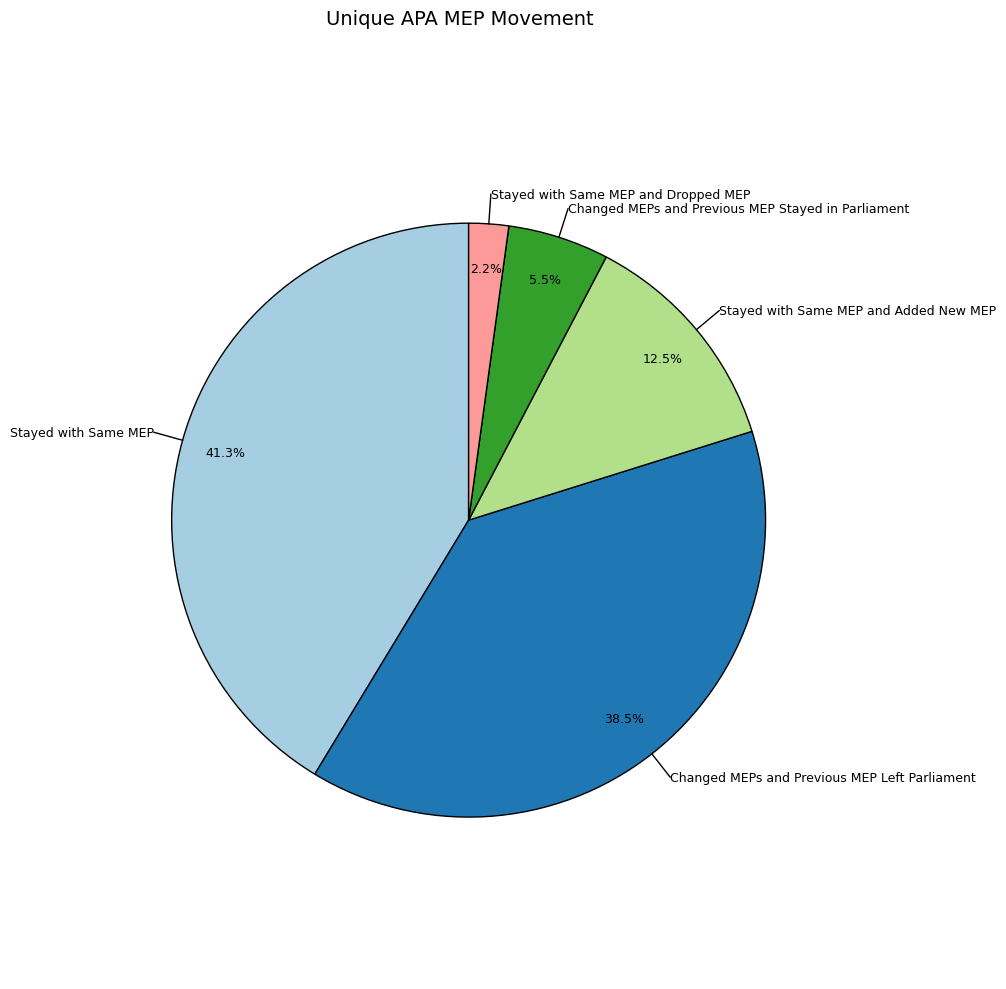

In [214]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Collect Term 10 MEPs
term_10_mep_set = set(filtered_apas_both_terms[filtered_apas_both_terms['term'] == 10]['mep_name'])

# Step 2: Process Term 9 and Term 10 Data
term_9_data = filtered_apas_both_terms[filtered_apas_both_terms['term'] == 9]
term_9_grouped = term_9_data.groupby('assistant_name').apply(
    lambda x: set(x['mep_name'])
).reset_index(name='term_9')

term_10_data = filtered_apas_both_terms[filtered_apas_both_terms['term'] == 10]
term_10_grouped = term_10_data.groupby('assistant_name').apply(
    lambda x: set(x['mep_name'])
).reset_index(name='term_10')

# Merge Results
meps_merged_data = pd.merge(term_9_grouped, term_10_grouped, on='assistant_name', how='outer')

# Step 3: Define categorization function for MEP movement
def categorize_mep(assistant, term_9_meps, term_10_meps, term_10_mep_set):
    term_9_set = term_9_meps.get(assistant, set())
    term_10_set = term_10_meps.get(assistant, set())

    # Case 1: Stayed with Same MEP (exact match in both Term 9 and Term 10)
    if term_9_set == term_10_set:
        return "Stayed with Same MEP"
    
    # Case 2: Stayed with Same MEP and Added New MEP (some common MEPs but also new ones in Term 10)
    stayed_mep = term_9_set & term_10_set  # Common MEPs
    new_mep = term_10_set - term_9_set     # New MEPs in Term 10
    if stayed_mep and new_mep:
        return "Stayed with Same MEP and Added New MEP"
    
    # Case 3: Stayed with Same MEP and Dropped MEP (some common MEPs but fewer in Term 10)
    if stayed_mep and len(stayed_mep) < len(term_9_set):
        return "Stayed with Same MEP and Dropped MEP"
    
    # Case 4: Changed MEPs - Previous MEP Left Parliament
    # This case occurs when the assistant had a Term 9 MEP that is no longer in Term 10
    left_mep = term_9_set - term_10_set  # MEPs that were in Term 9 but not in Term 10
    if left_mep and all(mep not in term_10_mep_set for mep in left_mep):
        return "Changed MEPs and Previous MEP Left Parliament"
    
    # Case 5: Changed MEPs - Previous MEP Stayed in Parliament
    # This case occurs when the assistant changes to a new MEP, but the previous MEP stayed in Parliament
    if left_mep and any(mep in term_10_mep_set for mep in left_mep):
        return "Changed MEPs and Previous MEP Stayed in Parliament"
    
    # Case 6: New MEP for APA (completely new to Term 10)
    if term_10_set and not term_9_set:
        return "New MEP for APA"

    # Default: Unexpected case (if no conditions match)
    return "Unexpected Case"

# Apply categorization for each assistant
meps_merged_data['mep_movement'] = meps_merged_data.apply(
    lambda row: categorize_mep(row['assistant_name'], 
                               term_9_grouped.set_index('assistant_name').to_dict()['term_9'], 
                               term_10_grouped.set_index('assistant_name').to_dict()['term_10'], 
                               term_10_mep_set), axis=1
)

# Step 4: Create a summary of movement categories
movement_summary = meps_merged_data['mep_movement'].value_counts()

# Print the summary
print("\nMovement Category Summary:")
print(movement_summary)

# Step 5: Print Unexpected Cases
unexpected_cases = meps_merged_data[meps_merged_data['mep_movement'] == "Unexpected Case"]
print("\nUnexpected Cases:")
print(unexpected_cases[['assistant_name', 'term_9', 'term_10', 'mep_movement']])

# Step 6: Print Changed MEPs Information
changed_meps = meps_merged_data[meps_merged_data['mep_movement'] == "Changed MEPs and Previous MEP Left Parliament"]
print("\nChanged MEPs and Previous MEP Left Parliament:")
print(changed_meps[['assistant_name', 'term_9', 'term_10', 'mep_movement']])

# Also print assistants who changed MEPs but their previous MEP stayed in Parliament
changed_meps_stayed = meps_merged_data[meps_merged_data['mep_movement'] == "Changed MEPs and Previous MEP Stayed in Parliament"]
print("\nChanged MEPs and Previous MEP Stayed in Parliament:")
print(changed_meps_stayed[['assistant_name', 'term_9', 'term_10', 'mep_movement']])

import numpy as np

# Step 7: Plot the movement categories as a pie chart
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Your previous code up to step 7

# Step 7: Plot the movement categories as a pie chart
plt.figure(figsize=(10, 10))  # Increase figure size to prevent label overlap

# Plot the pie chart with movement summary index as labels
wedges, texts, autotexts = plt.pie(movement_summary, 
                                   labels=movement_summary.index,  # Use movement categories as labels
                                   autopct='%1.1f%%', 
                                   startangle=90, 
                                   colors=plt.cm.Paired.colors, 
                                   textprops={'fontsize': 9}, 
                                   wedgeprops={'edgecolor': 'black'},  # Add border around slices
                                   pctdistance=0.85,  # Place percentage closer to the center
                                   labeldistance=1.1)  # Place label farther out from the center

# Adding lines pointing to the labels from the edge of the pie
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2  # Calculate the angle of the slice
    
    # Calculate the x and y coordinates on the edge of the pie
    x_edge = 1.0 * np.cos(np.radians(angle))  # x-coordinate at the edge
    y_edge = 1.0 * np.sin(np.radians(angle))  # y-coordinate at the edge
    
    # Position for the label line end (already placed farther out at 1.1)
    x_label = 1.1 * np.cos(np.radians(angle))  # Slightly farther for label placement
    y_label = 1.1 * np.sin(np.radians(angle))
    
    # Draw a line from the edge of the pie slice to the label position
    plt.plot([x_edge, x_label], [y_edge, y_label], color='black', lw=1)

# Adjust the layout to prevent overlap
plt.title("Unique APA MEP Movement", fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout to give more space around the plot
#plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Show the pie chart
plt.tight_layout()
plt.show()


### 4.1.4 MEP Movement Counts

In [167]:
# Count how many MEPs each assistant worked for in term_9
mep_counts = meps_merged_data['term_9'].apply(len)

# Calculate the required counts
unique_people_for_one_mep = (mep_counts == 1).sum()
unique_people_for_multiple_meps = (mep_counts > 1).sum()

# Print results
print(f"Number of unique people that worked for 1 MEP in the 9th term: {unique_people_for_one_mep}")
print(f"Number of unique people that worked for more than 1 MEP in the 9th term: {unique_people_for_multiple_meps}")

Number of unique people that worked for 1 MEP in the 9th term: 521
Number of unique people that worked for more than 1 MEP in the 9th term: 79


now for all ninth term and tenth term counts


In [173]:
# Step 2: Process Term 9 and Term 10 Data
term_9_data = filtered_apas[filtered_apas['term'] == 9]
term_9_grouped_all = term_9_data.groupby('assistant_name').apply(
    lambda x: set(x['mep_name'])
).reset_index(name='term_9')

term_10_data = filtered_apas[filtered_apas['term'] == 10]
term_10_grouped_all = term_10_data.groupby('assistant_name').apply(
    lambda x: set(x['mep_name'])
).reset_index(name='term_10')

# Merge Results
#meps_merged_data_all = pd.merge(term_9_grouped, term_10_grouped, on='assistant_name', how='outer')
print(term_9_grouped_all.columns)

# Count how many MEPs each assistant worked for in term_9
term9_mep_counts = term_9_grouped_all['term_9'].apply(len)
term10_mep_counts = term_10_grouped_all['term_10'].apply(len)

# Calculate the required counts
term9_unique_people_for_one_mep = (term9_mep_counts == 1).sum()
term9_unique_people_for_multiple_meps = (term9_mep_counts > 1).sum()

term10_unique_people_for_one_mep = (term10_mep_counts == 1).sum()
term10_unique_people_for_multiple_meps = (term10_mep_counts > 1).sum()

# Print results
print(f"Number of unique people that worked for 1 MEP in the 9th term: {term9_unique_people_for_one_mep}")
print(f"Number of unique people that worked for more than 1 MEP in the 9th term: {term9_unique_people_for_multiple_meps}")
# Print results
print(f"Number of unique people that worked for 1 MEP in the 10th term: {term10_unique_people_for_one_mep}")
print(f"Number of unique people that worked for more than 1 MEP in the 10th term: {term10_unique_people_for_multiple_meps}")

C:\Users\Emilia\AppData\Local\Temp\ipykernel_25844\265055627.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  term_9_grouped_all = term_9_data.groupby('assistant_name').apply(


Index(['assistant_name', 'term_9'], dtype='object')
Number of unique people that worked for 1 MEP in the 9th term: 1477
Number of unique people that worked for more than 1 MEP in the 9th term: 225
Number of unique people that worked for 1 MEP in the 10th term: 1636
Number of unique people that worked for more than 1 MEP in the 10th term: 354


C:\Users\Emilia\AppData\Local\Temp\ipykernel_25844\265055627.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  term_10_grouped_all = term_10_data.groupby('assistant_name').apply(


### 4.1.4 Relationship level visualization 

C:\Users\Emilia\AppData\Local\Temp\ipykernel_25844\2483982722.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  term_9_grouped = term_9_data.groupby('assistant_name').apply(
C:\Users\Emilia\AppData\Local\Temp\ipykernel_25844\2483982722.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  term_10_grouped = term_10_data.groupby('assistant_name').apply(


                    assistant_name                         term_9  \
0    AMANDA ELISABET ANNIE ARLEKLO                 {Alice KUHNKE}   
1                     Abel PASZTOR                   {Andor DELI}   
2                    Adam MOUCHTAR  {Franc BOGOVIČ, Engin EROGLU}   
3                  Adrian NAUGHTON                 {Mick WALLACE}   
4          Adriana-Roxana ANDRONIC        {Cristian-Silviu BUŞOI}   
..                             ...                            ...   
595                Zaritsa DINKOVA                  {Radan KANEV}   
596                  Zoltán PANCZA               {István UJHELYI}   
597               Zsuzsanna PATAKI                {Iuliu WINKLER}   
598                Zuzana LAHOUSSE            {Luděk NIEDERMAYER}   
599                    Özlem DENIZ            {Gabriele BISCHOFF}   

                                          term_10  
0    {Pär HOLMGREN, Isabella LÖVIN, Alice KUHNKE}  
1                              {Annamária VICSEK}  
2              

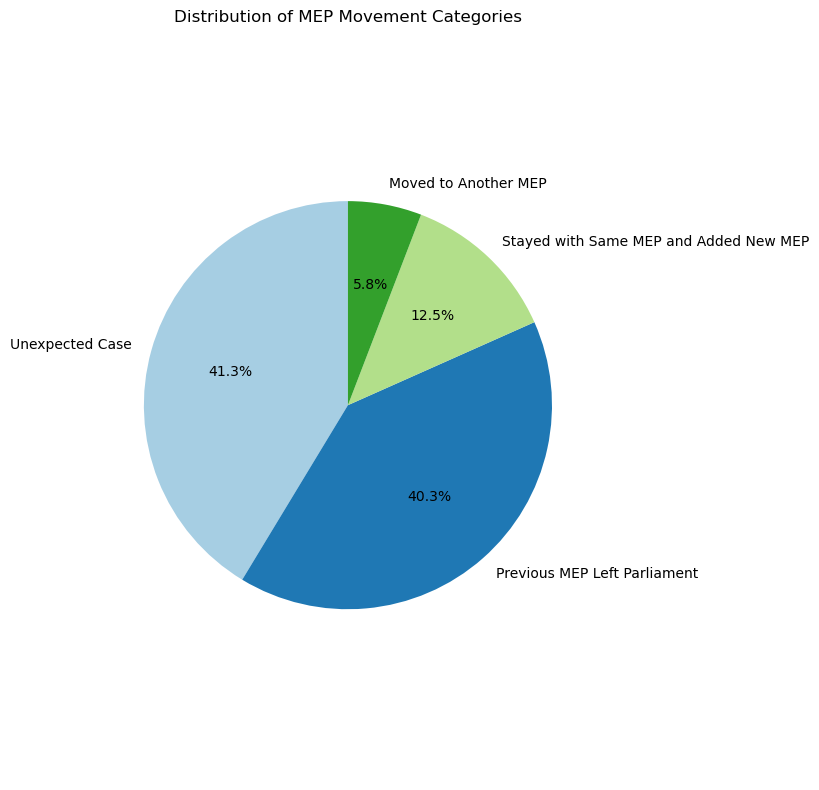

In [197]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Collect Term 10 MEPs
term_10_mep_set = set(filtered_apas_both_terms[filtered_apas_both_terms['term'] == 10]['mep_name'])

# Step 0: Check the total number of unique assistants
print("Total unique assistants in dataset:", len(filtered_apas_both_terms['assistant_name'].unique()))  # Should be 2343

# Step 1: Create exploded data for Term 9 and Term 10
term_9_data = filtered_apas_both_terms[filtered_apas_both_terms['term'] == 9]
term_10_data = filtered_apas_both_terms[filtered_apas_both_terms['term'] == 10]

# Explode the datasets to make MEP associations explicit
term_9_exploded = term_9_data.groupby('assistant_name').apply(
    lambda x: pd.DataFrame({'assistant_name': x['assistant_name'], 'mep_name': x['mep_name']})
).reset_index(drop=True)

term_10_exploded = term_10_data.groupby('assistant_name').apply(
    lambda x: pd.DataFrame({'assistant_name': x['assistant_name'], 'mep_name': x['mep_name']})
).reset_index(drop=True)

print("Unique assistants in Term 9:", len(term_9_exploded['assistant_name'].unique()))  # Should match Term 9 count
print("Unique assistants in Term 10:", len(term_10_exploded['assistant_name'].unique()))  # Should match Term 10 count

# Step 2: Compare Term 9 and Term 10 by assistant and MEP
# Create sets of MEPs for easier lookup
term_9_meps = term_9_exploded.groupby('assistant_name')['mep_name'].apply(set).to_dict()
term_10_meps = term_10_exploded.groupby('assistant_name')['mep_name'].apply(set).to_dict()

# Initialize a list to store assistants and MEPs that match Case 2b (Moved to Another MEP, Previous MEP still in Parliament)
case_2b_matches = []

def categorize_mep(assistant, mep, term_9_meps, term_10_meps, term_10_mep_set):
    term_9_set = term_9_meps.get(assistant, set())
    term_10_set = term_10_meps.get(assistant, set())
    
    # Case 1: Same MEP in both terms
    if mep in term_9_set and mep in term_10_set:
        return "Stayed with Same MEP"
    
    # Case 2: MEP in Term 9 but not in Term 10 (left Parliament or assistant moved)
    if mep in term_9_set and mep not in term_10_set:
        if mep not in term_10_mep_set:
            return "Previous MEP Left Parliament"
        else:
            # This is the Case 2b: Assistant moved to another MEP, but the previous MEP is still in Parliament
            # We want to capture this specific case, but only if the assistant is not just missing from Term 10:
            case_2b_matches.append({'assistant_name': assistant, 'mep_name': mep})
            return "Moved to Another MEP (Previous MEP still in Parliament)"
    
    # Case 3: New MEP in Term 10 (not in Term 9 at all)
    if mep in term_10_set and mep not in term_9_set:
        return "New MEP for APA"
    
    # Case 4: Assistant moved to a new MEP, but the previous MEP is still in Parliament
    if mep not in term_9_set and mep in term_10_set:
        if mep in term_10_mep_set:
            return "Moved to New MEP, but Previous MEP still in Parliament"
    
    # If none of the above cases match
    return "Unexpected Case"

# Compare Term 9 MEPs
for assistant, meps in term_9_meps.items():
    for mep in meps:
        categorize_mep(assistant, mep, term_9_meps, term_10_meps, term_10_mep_set)

# Now print the results for Case 2b matches
print("Case 2b Matches (Moved to Another MEP, Previous MEP still in Parliament):")
for match in case_2b_matches:
    print(f"Assistant: {match['assistant_name']}, MEP: {match['mep_name']}")

# Alternatively, if you'd like to store them in a DataFrame for better inspection:
case_2b_df = pd.DataFrame(case_2b_matches)
print(case_2b_df)

# Step 3: Apply logic to create a detailed comparison table
term_10_mep_set = set(term_10_exploded['mep_name'])  # All MEPs in Term 10 for "left" check

comparison_rows = []
test_cases = []  # Store rows where the category is 'test'

# Compare Term 9 MEPs
for assistant, meps in term_9_meps.items():
    for mep in meps:
        category = categorize_mep(assistant, mep, term_9_meps, term_10_meps, term_10_mep_set)
        if category == 'Moved to a New MEP for APA':  # Log instances of unexpected categories
            test_cases.append({'assistant_name': assistant, 'mep_name': mep, 'term': 9})
        comparison_rows.append({'assistant_name': assistant, 'mep_name': mep, 'category': category, 'term': 9})

# Compare Term 10 MEPs
for assistant, meps in term_10_meps.items():
    for mep in meps:
        category = categorize_mep(assistant, mep, term_9_meps, term_10_meps, term_10_mep_set)
        if category == 'Moved to a New MEP for APA':  # Log instances of unexpected categories
            test_cases.append({'assistant_name': assistant, 'mep_name': mep, 'term': 10})
        if category:  # Only add if not already covered in Term 9 logic
            comparison_rows.append({'assistant_name': assistant, 'mep_name': mep, 'category': category, 'term': 10})

# Convert comparison rows to a DataFrame
comparison_df = pd.DataFrame(comparison_rows)

# Step 4: Check for missing assistants
processed_assistants = set(comparison_df['assistant_name'].unique())
original_assistants = set(filtered_apas_both_terms['assistant_name'].unique())
missing_assistants = original_assistants - processed_assistants

print("Number of assistants in final comparison:", len(processed_assistants))
print("Number of missing assistants:", len(missing_assistants))
if missing_assistants:
    print("Missing assistants:", missing_assistants)

# Step 5: Print instances of 'test' category for inspection
if test_cases:
    test_cases_df = pd.DataFrame(test_cases)
    print("\nInstances categorized as 'test':")
    print(test_cases_df)
else:
    print("\nNo instances categorized as 'test'.")

# Step 6: Summarize and Visualize
summary = comparison_df['category'].value_counts()
print("\nCategory Summary:")
print(summary)

# Pie chart for visualizing categories
labels = summary.index
sizes = summary.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('MEP Movement Categories')
plt.show()

## 4.2 Faction Movement

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter and explode data for Term 9 and Term 10
term_9_data = filtered_apas_both_terms[filtered_apas_both_terms['term'] == 9]
term_9_grouped_faction = term_9_data.groupby('assistant_name')['group_abbr'].apply(
    lambda x: set(x)
).reset_index(name='term_9')

term_10_data = filtered_apas_both_terms[filtered_apas_both_terms['term'] == 10]
term_10_grouped_faction = term_10_data.groupby('assistant_name')['group_abbr'].apply(
    lambda x: set(x)
).reset_index(name='term_10')

# Step 2: Merge the two datasets based on 'assistant_name'
faction_merged_data = pd.merge(term_9_grouped_faction, term_10_grouped_faction, on='assistant_name', how='outer')
print(faction_merged_data)

                    assistant_name        term_9     term_10
0    AMANDA ELISABET ANNIE ARLEKLO       {G/EFA}     {G/EFA}
1                     Abel PASZTOR         {EPP}  {Patriots}
2                    Adam MOUCHTAR  {EPP, Renew}     {Renew}
3                  Adrian NAUGHTON     {GUE/NGL}   {GUE/NGL}
4          Adriana-Roxana ANDRONIC         {EPP}       {EPP}
..                             ...           ...         ...
595                Zaritsa DINKOVA         {EPP}       {EPP}
596                  Zoltán PANCZA         {S&D}       {EPP}
597               Zsuzsanna PATAKI         {EPP}       {EPP}
598                Zuzana LAHOUSSE         {EPP}       {EPP}
599                    Özlem DENIZ         {S&D}       {S&D}

[600 rows x 3 columns]


In [194]:
# Step 1: Explode term_9 and term_10 into separate rows
term_9_exploded = faction_merged_data[['assistant_name', 'term_9']].explode('term_9')
term_9_exploded.rename(columns={'term_9': 'Faction'}, inplace=True)
term_9_exploded['Term'] = 9

term_10_exploded = faction_merged_data[['assistant_name', 'term_10']].explode('term_10')
term_10_exploded.rename(columns={'term_10': 'Faction'}, inplace=True)
term_10_exploded['Term'] = 10

# Step 2: Combine exploded data for both terms
exploded_data = pd.concat([term_9_exploded, term_10_exploded], ignore_index=True)

# Step 3: Count assistants associated with each faction
faction_counts = exploded_data.groupby(['Faction', 'Term']).size().reset_index(name='Assistant Count')

# Step 4: Display the result
print(faction_counts)

     Faction  Term  Assistant Count
0        ECR     9               50
1        ECR    10               64
2        EPP     9              155
3        EPP    10              144
4        ESN    10               15
5      G/EFA     9               59
6      G/EFA    10               55
7    GUE/NGL     9               34
8    GUE/NGL    10               45
9         ID     9               54
10        NI     9               25
11        NI    10               15
12  Patriots    10               58
13     Renew     9               81
14     Renew    10               75
15       S&D     9              150
16       S&D    10              134


Change    Joined  Left  Stayed
Faction                       
ECR           24    10      40
EPP           19    30     125
ESN           15     0       0
G/EFA          1     5      54
GUE/NGL       17     6      28
ID             0    54       0
NI            13    23       2
Patriots      58     0       0
Renew         11    17      64
S&D            2    18     132


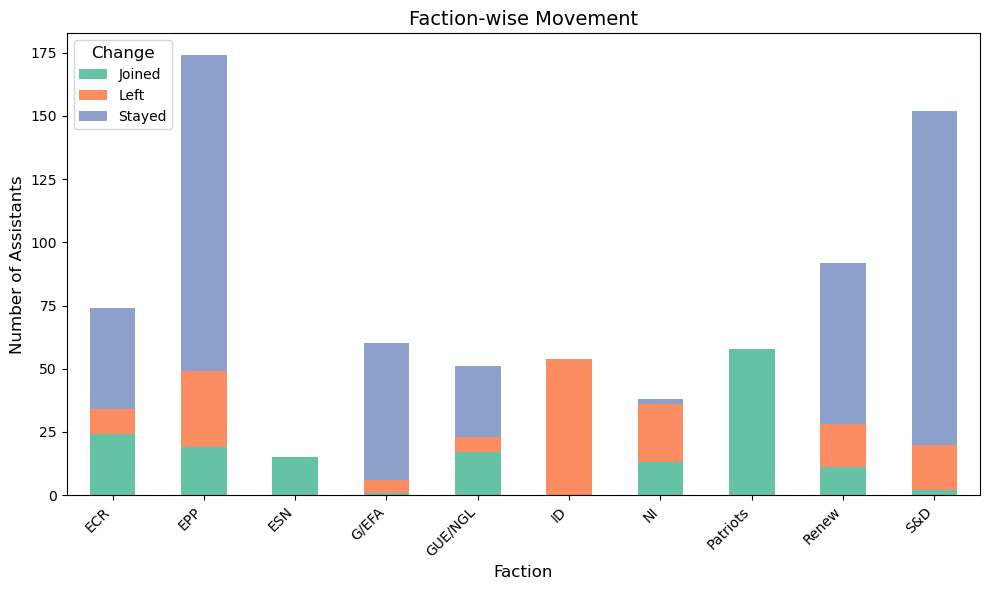

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to classify party changes
def classify_party_changes(row):
    term_9 = row['term_9']
    term_10 = row['term_10']
    
    stayed = term_9 & term_10  # Intersection of sets
    left = term_9 - term_10    # Parties in term_9 but not in term_10
    joined = term_10 - term_9  # Parties in term_10 but not in term_9
    
    # Overall movement status
    if stayed == term_9 == term_10:
        movement_status = "Stayed"
    elif len(left) == 0 and len(joined) > 0:
        movement_status = "Expanded"
    elif len(left) > 0 and len(joined) == 0:
        movement_status = "Reduced"
    else:
        movement_status = "Moved"

    # Create a record for each faction
    faction_changes = []
    for faction in term_9 | term_10:
        if faction in stayed:
            faction_changes.append((faction, "Stayed"))
        if faction in left:
            faction_changes.append((faction, "Left"))
        if faction in joined:
            faction_changes.append((faction, "Joined"))

    return pd.DataFrame(faction_changes, columns=["Faction", "Change"]), movement_status

# Apply classification function
all_faction_changes = []
movement_statuses = []
for _, row in faction_merged_data.iterrows():
    faction_changes, movement_status = classify_party_changes(row)
    all_faction_changes.append(faction_changes)
    movement_statuses.append(movement_status)

# Combine faction changes into one DataFrame
faction_changes_df = pd.concat(all_faction_changes).reset_index(drop=True)

# Add movement statuses to original DataFrame
faction_merged_data['Movement Status'] = movement_statuses

# Count categories per faction
faction_summary = faction_changes_df.groupby(['Faction', 'Change']).size().unstack(fill_value=0)
print(faction_summary)

import matplotlib.pyplot as plt
import seaborn as sns

# Set a custom color palette for the chart
custom_palette = sns.color_palette('Set2')  # Aesthetic and distinct colors from seaborn

# Plot stacked bar chart with the custom palette
faction_summary.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_palette)
plt.title("Faction-wise Movement", fontsize=14)
plt.xlabel("Faction", fontsize=12)
plt.ylabel("Number of Assistants", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Change", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

Joined   ECR  EPP  ESN  G/EFA  GUE/NGL  NI  Patriots  Renew  S&D
Left                                                            
ECR        0    4    1      0        0   1         4      0    0
EPP        5    0    0      0        0   1        15      8    0
G/EFA      0    0    0      0        3   0         0      1    1
GUE/NGL    0    0    0      0        0   6         0      0    0
ID        14    1   12      0        0   0        28      0    0
NI         1    2    0      1       15   0         4      0    0
Renew      1    8    0      0        0   0         5      0    1
S&D        3    5    1      0        0   5         2      2    0
Assistants who left a faction but did not join a new one:
Adam MOUCHTAR
Jeremie HABIG
Ulla Helena GROENLUND


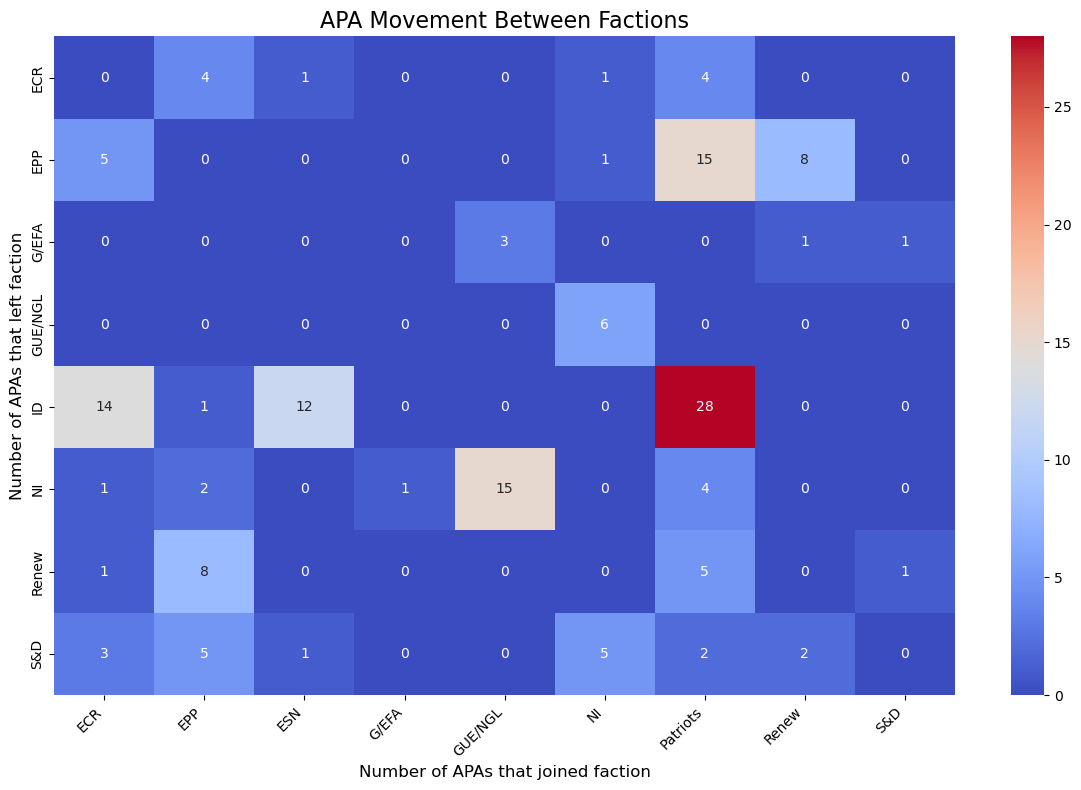

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to classify party changes
def classify_party_changes(row):
    term_9 = row['term_9']
    term_10 = row['term_10']
    
    stayed = term_9 & term_10  # Intersection of sets
    left = term_9 - term_10    # Parties in term_9 but not in term_10
    joined = term_10 - term_9  # Parties in term_10 but not in term_9
    
    # Overall movement status
    if stayed == term_9 == term_10:
        movement_status = "Stayed"
    elif len(left) == 0 and len(joined) > 0:
        movement_status = "Expanded"
    elif len(left) > 0 and len(joined) == 0:
        movement_status = "Reduced"
    else:
        movement_status = "Moved"

    # Create a record for each faction
    faction_changes = []
    for faction in term_9 | term_10:
        if faction in stayed:
            faction_changes.append((faction, "Stayed"))
        if faction in left:
            faction_changes.append((faction, "Left"))
        if faction in joined:
            faction_changes.append((faction, "Joined"))

    return pd.DataFrame(faction_changes, columns=["Faction", "Change"]), movement_status, left, joined

# Apply classification function
all_faction_changes = []
movement_statuses = []
left_joined_pairs = []  # To track (Left -> Joined) pairs
left_no_joined = []  # To track assistants who left but did not join a new faction

for _, row in faction_merged_data.iterrows():
    faction_changes, movement_status, left, joined = classify_party_changes(row)
    all_faction_changes.append(faction_changes)
    movement_statuses.append(movement_status)
    for l in left:
        for j in joined:
            left_joined_pairs.append((l, j))
    
    # If the assistant left but didn't join a new faction
    if len(left) > 0 and len(joined) == 0:
        left_no_joined.append(row['assistant_name'])

# Combine faction changes into one DataFrame
faction_changes_df = pd.concat(all_faction_changes).reset_index(drop=True)

# Add movement statuses to original DataFrame
faction_merged_data['Movement Status'] = movement_statuses

# Create a summary DataFrame for left-to-joined movements
left_to_joined_df = pd.DataFrame(left_joined_pairs, columns=["Left", "Joined"])

# Create a summary table
left_to_joined_summary = left_to_joined_df.groupby(["Left", "Joined"]).size().unstack(fill_value=0)
print(left_to_joined_summary)

# Print assistants who left but did not join a new faction
print("Assistants who left a faction but did not join a new one:")
for assistant in left_no_joined:
    print(assistant)

# Visualization: Heatmap for Left -> Joined transitions
plt.figure(figsize=(12, 8))
sns.heatmap(left_to_joined_summary, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title("APA Movement Between Factions", fontsize=16)
plt.xlabel("Number of APAs that joined faction", fontsize=12)
plt.ylabel("Number of APAs that left faction", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### OLD CODE 

In [ ]:
# Step 3: Define the categorization logic for faction-by-faction comparison
def categorize_faction_changes(row):
    term_9_factions = row['factions_term_9'] or set()
    term_10_factions = row['factions_term_10'] or set()
    
    # To track each faction's movement
    movement_categories = []
    
    # Iterate over factions in Term 9 and check their status in Term 10
    for faction_9 in term_9_factions:
        if faction_9 in term_10_factions:
            movement_categories.append(f"{faction_9[0]} stayed in the same faction")  # Access the first value in the tuple
        else:
            movement_categories.append(f"{faction_9[0]} left a faction in Term 9")
    
    # Iterate over factions in Term 10 and check their status in Term 9
    for faction_10 in term_10_factions:
        if faction_10 not in term_9_factions:
            movement_categories.append(f"{faction_10[0]} is a new faction in Term 10")
    
    # Return a list of movement categories
    return movement_categories

# Step 4: Apply the categorization function to each row
faction_merged_data['faction_changes'] = faction_merged_data.apply(categorize_faction_changes, axis=1)

# Step 5: Flatten the data into a new dataframe where each row represents a faction change
faction_changes_expanded = faction_merged_data.explode('faction_changes')

# Step 6: Track and count the faction movements
category_summary = faction_changes_expanded['faction_changes'].value_counts()
print("\nCategory Summary:")
print(category_summary)

# Step 7: Create a grouped bar chart for 'stayed' and 'moved'
# Create cleaned group names
def clean_group_name(category):
    return category.split()[0]  # Extract group name before the space

faction_changes_expanded['group'] = faction_changes_expanded['faction_changes'].apply(clean_group_name)
faction_changes_expanded['movement'] = faction_changes_expanded['faction_changes'].apply(
    lambda x: 'moved' if 'left' in x or 'new' in x else 'stayed'
)

# Aggregate data for the plot
plot_data = faction_changes_expanded.groupby(['group', 'movement']).size().unstack(fill_value=0)

# Plot
plot_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=['#76b5c5', '#ff6f61'])
plt.title('Faction Movements: Stayed vs. Moved', fontsize=16)
plt.xlabel('Faction Groups', fontsize=14)
plt.ylabel('Number of Assistants', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Movement', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

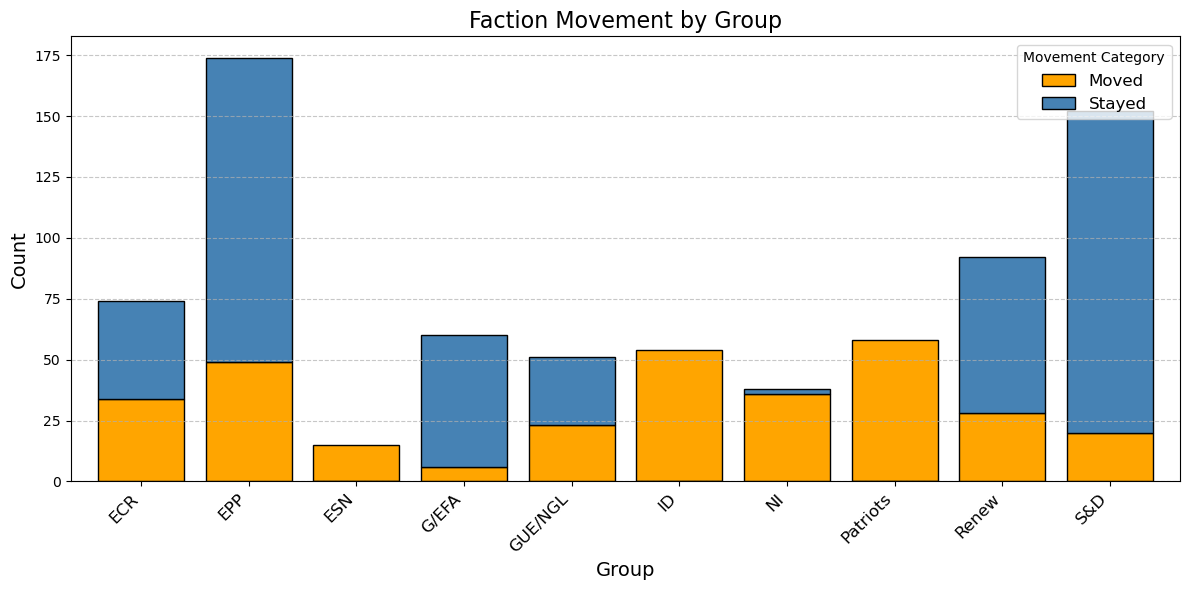

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming faction_changes_expanded is already created from the previous steps

# Step 1: Extract clean group names and movement type
faction_changes_expanded['Group'] = faction_changes_expanded['faction_changes'].str.extract(r"\('(.+?)',\)")
faction_changes_expanded['Movement'] = faction_changes_expanded['faction_changes'].str.extract(r"(stayed|left|is a new)")

# Step 2: Classify movements into "Stayed" and "Moved"
def classify_movement(movement):
    if movement == "stayed":
        return "Stayed"
    else:
        return "Moved"

faction_changes_expanded['Movement_Category'] = faction_changes_expanded['Movement'].apply(classify_movement)

# Step 3: Group by Group name and Movement_Category
movement_summary = faction_changes_expanded.groupby(['Group', 'Movement_Category']).size().unstack(fill_value=0)

# Step 4: Plot the stacked bar chart
plt.figure(figsize=(12, 6))

movement_summary.plot(
    kind="bar",
    stacked=True,
    color={"Stayed": "steelblue", "Moved": "orange"},
    figsize=(12, 6),
    edgecolor="black",
    width=0.8
)

# Step 5: Customize the plot
plt.title("Faction Movement by Group", fontsize=16)
plt.xlabel("Group", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.legend(title="Movement Category", fontsize=12, loc='upper right')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

## 4.3 Movement by Party

### 4.3.1 Explore Parties

In [257]:
from fuzzywuzzy import fuzz
import pandas as pd

# Function to find similar party names and display results clearly
def find_similar_parties_readable(df, threshold=95):
    similar_pairs = []

    # Extract unique party names
    parties = df['mep_party'].unique()

    # Compare each pair of party names
    for i in range(len(parties)):
        for j in range(i + 1, len(parties)):
            # Calculate similarity score
            score = fuzz.ratio(parties[i].lower(), parties[j].lower())
            
            if score >= threshold:  # Use the desired threshold
                similar_pairs.append((parties[i], parties[j], score))

    # Convert the results to a DataFrame for better readability
    similar_pairs_df = pd.DataFrame(similar_pairs, columns=["Party 1", "Party 2", "Similarity Score"])
    return similar_pairs_df

# Update MEP party assignments
filtered_apas_both_terms.loc[
    (filtered_apas_both_terms['mep_name'] == 'Mislav KOLAKUŠIĆ') & (filtered_apas_both_terms['term'] == 9),
    'mep_party'
] = 'PRAVO I PRAVDA'

filtered_apas_both_terms.loc[
    (filtered_apas_both_terms['mep_name'] == 'Stéphanie YON-COURTIN') & (filtered_apas_both_terms['term'] == 9),
    'mep_party'
] = 'Renaissance'

# Remap party names to standardized ones
party_mapping = {
    "FRATELLI D' ITALIA": "Fratelli d'Italia", 
    "Parti socialiste": "Parti Socialiste",
    "Liste Renaissance": "Renaissance"
}
filtered_apas_both_terms['mep_party'] = filtered_apas_both_terms['mep_party'].replace(party_mapping)

# Handle "Independent" in European languages
independent_variations = [
    "independent", "indépendant", "indipendente", "unabhängig", "nezávislý",
    "nezávislá", "uafhængig", "zelfstandig", "oberoende", "samostojno",
    "nepriklausomas", "onafhankelijk", "independente", "nezavisni",
    "nepriklausoma", "nezavisna", "nezavisno", "nezávislé", "niezależny",
    "niezależna", "dependent", "pavarur", "pavarësisë", "obraded", "independiente"
]

# Convert all instances of "independent" to "Independent" and print if found
found_independent = filtered_apas_both_terms[filtered_apas_both_terms['mep_party'].str.lower().isin(independent_variations)]
if not found_independent.empty:
    print("\nInstances of 'Independent' in different languages found:")
    print(found_independent[['mep_name', 'mep_party', 'term']].to_string(index=False))
    filtered_apas_both_terms['mep_party'] = filtered_apas_both_terms['mep_party'].apply(
        lambda x: "Independent" if x.lower() in independent_variations else x
    )
else:
    print("\nNo instances of 'Independent' in different languages found.")

# Run the fuzzy matching function
print("\nChecking for similar party names after normalization:")
similar_party_names_df = find_similar_parties_readable(filtered_apas_both_terms)
if not similar_party_names_df.empty:
    print(similar_party_names_df.to_string(index=False))  # Print without row indices for cleaner output
else:
    print("\nNo similar party names detected after normalization.")

C:\Users\Emilia\AppData\Local\Temp\ipykernel_25844\1474155959.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_apas_both_terms['mep_party'] = filtered_apas_both_terms['mep_party'].replace(party_mapping)



Instances of 'Independent' in different languages found:
              mep_name     mep_party  term
            Clare DALY   Independent     9
            Clare DALY   Independent     9
        Dino GIARRUSSO   Independent     9
           Hervé JUVIN   Independent     9
           Hervé JUVIN   Independent     9
       Janina OCHOJSKA   Independent     9
           Javier NART Independiente     9
           Javier NART Independiente     9
    Luke Ming FLANAGAN   Independent     9
    Luke Ming FLANAGAN   Independent     9
    Luke Ming FLANAGAN   Independent     9
   Magdalena ADAMOWICZ   Independent     9
         Michal WIEZIK   Independent     9
   Magdalena ADAMOWICZ   Independent    10
   Magdalena ADAMOWICZ   Independent    10
   Magdalena ADAMOWICZ   Independent    10
     Sebastião BUGALHO   Independent    10
     Sebastião BUGALHO   Independent    10
     Sebastião BUGALHO   Independent    10
     Sebastião BUGALHO   Independent    10
         Ondřej DOSTÁL   Independent   

C:\Users\Emilia\AppData\Local\Temp\ipykernel_25844\1474155959.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_apas_both_terms['mep_party'] = filtered_apas_both_terms['mep_party'].apply(



No similar party names detected after normalization.


In [258]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter and explode data for Term 9 and Term 10
term_9_data = filtered_apas_both_terms[filtered_apas_both_terms['term'] == 9]
term_9_grouped_party = term_9_data.groupby('assistant_name')['mep_party'].apply(
    lambda x: set(x)
).reset_index(name='term_9')

term_10_data = filtered_apas_both_terms[filtered_apas_both_terms['term'] == 10]
term_10_grouped_party = term_10_data.groupby('assistant_name')['mep_party'].apply(
    lambda x: set(x)
).reset_index(name='term_10')

# Step 2: Merge the two datasets based on 'assistant_name'
party_merged_data = pd.merge(term_9_grouped_party, term_10_grouped_party, on='assistant_name', how='outer')
print(party_merged_data)

# save to an excel
#party_merged_data.to_excel('assistants_by_party.xlsx', index=False, engine='openpyxl')

                    assistant_name  \
0    AMANDA ELISABET ANNIE ARLEKLO   
1                     Abel PASZTOR   
2                    Adam MOUCHTAR   
3                  Adrian NAUGHTON   
4          Adriana-Roxana ANDRONIC   
..                             ...   
595                Zaritsa DINKOVA   
596                  Zoltán PANCZA   
597               Zsuzsanna PATAKI   
598                Zuzana LAHOUSSE   
599                    Özlem DENIZ   

                                                term_9  \
0                              {Miljöpartiet de gröna}   
1    {Fidesz-Magyar Polgári Szövetség-Kereszténydem...   
2            {Slovenska ljudska stranka, Freie Wähler}   
3                            {Independents for change}   
4                          {Partidul Naţional Liberal}   
..                                                 ...   
595                    {Democrats for Strong Bulgaria}   
596                          {Magyar Szocialista Párt}   
597           {Uniune

In [259]:
# Step 1: Explode term_9 and term_10 into separate rows
term_9_exploded = party_merged_data[['assistant_name', 'term_9']].explode('term_9')
term_9_exploded.rename(columns={'term_9': 'Party'}, inplace=True)
term_9_exploded['Term'] = 9

term_10_exploded = party_merged_data[['assistant_name', 'term_10']].explode('term_10')
term_10_exploded.rename(columns={'term_10': 'Party'}, inplace=True)
term_10_exploded['Term'] = 10

# Step 2: Combine exploded data for both terms
exploded_data = pd.concat([term_9_exploded, term_10_exploded], ignore_index=True)

# Step 3: Count assistants associated with each faction
party_counts = exploded_data.groupby(['Party', 'Term']).size().reset_index(name='Assistant Count')

# Step 4: Display the result
print(party_counts)

                                            Party  Term  Assistant Count
0            "Saskaņa" sociāldemokrātiskā partija     9                1
1            "Saskaņa" sociāldemokrātiskā partija    10                1
2                                         50 PLUS     9                1
3                                        ANO 2011     9                6
4                                        ANO 2011    10                3
..                                            ...   ...              ...
306  We continue the change – Democratic Bulgaria    10                1
307                                        Wiosna     9                3
308               Ökologisch-Demokratische Partei     9                1
309                   Österreichische Volkspartei     9                4
310                   Österreichische Volkspartei    10                3

[311 rows x 3 columns]


Change                                              Joined  Left  Stayed  \
Party                                                                      
independent                                             10     8       5   
fratelli d italia                                       12     0      11   
lega                                                     2    10       4   
renaissance                                              3     7       3   
europe écologie                                          0     8       0   
les écologistes                                          7     0       0   
platforma obywatelska                                    7     0      11   
forza italia                                             3     3       4   
rassemblement national                                   2     4      18   
bündnis sahra wagenknecht – vernunft und gerech...       5     0       0   
lista marjana šarca                                      0     5       0   
partit dels 

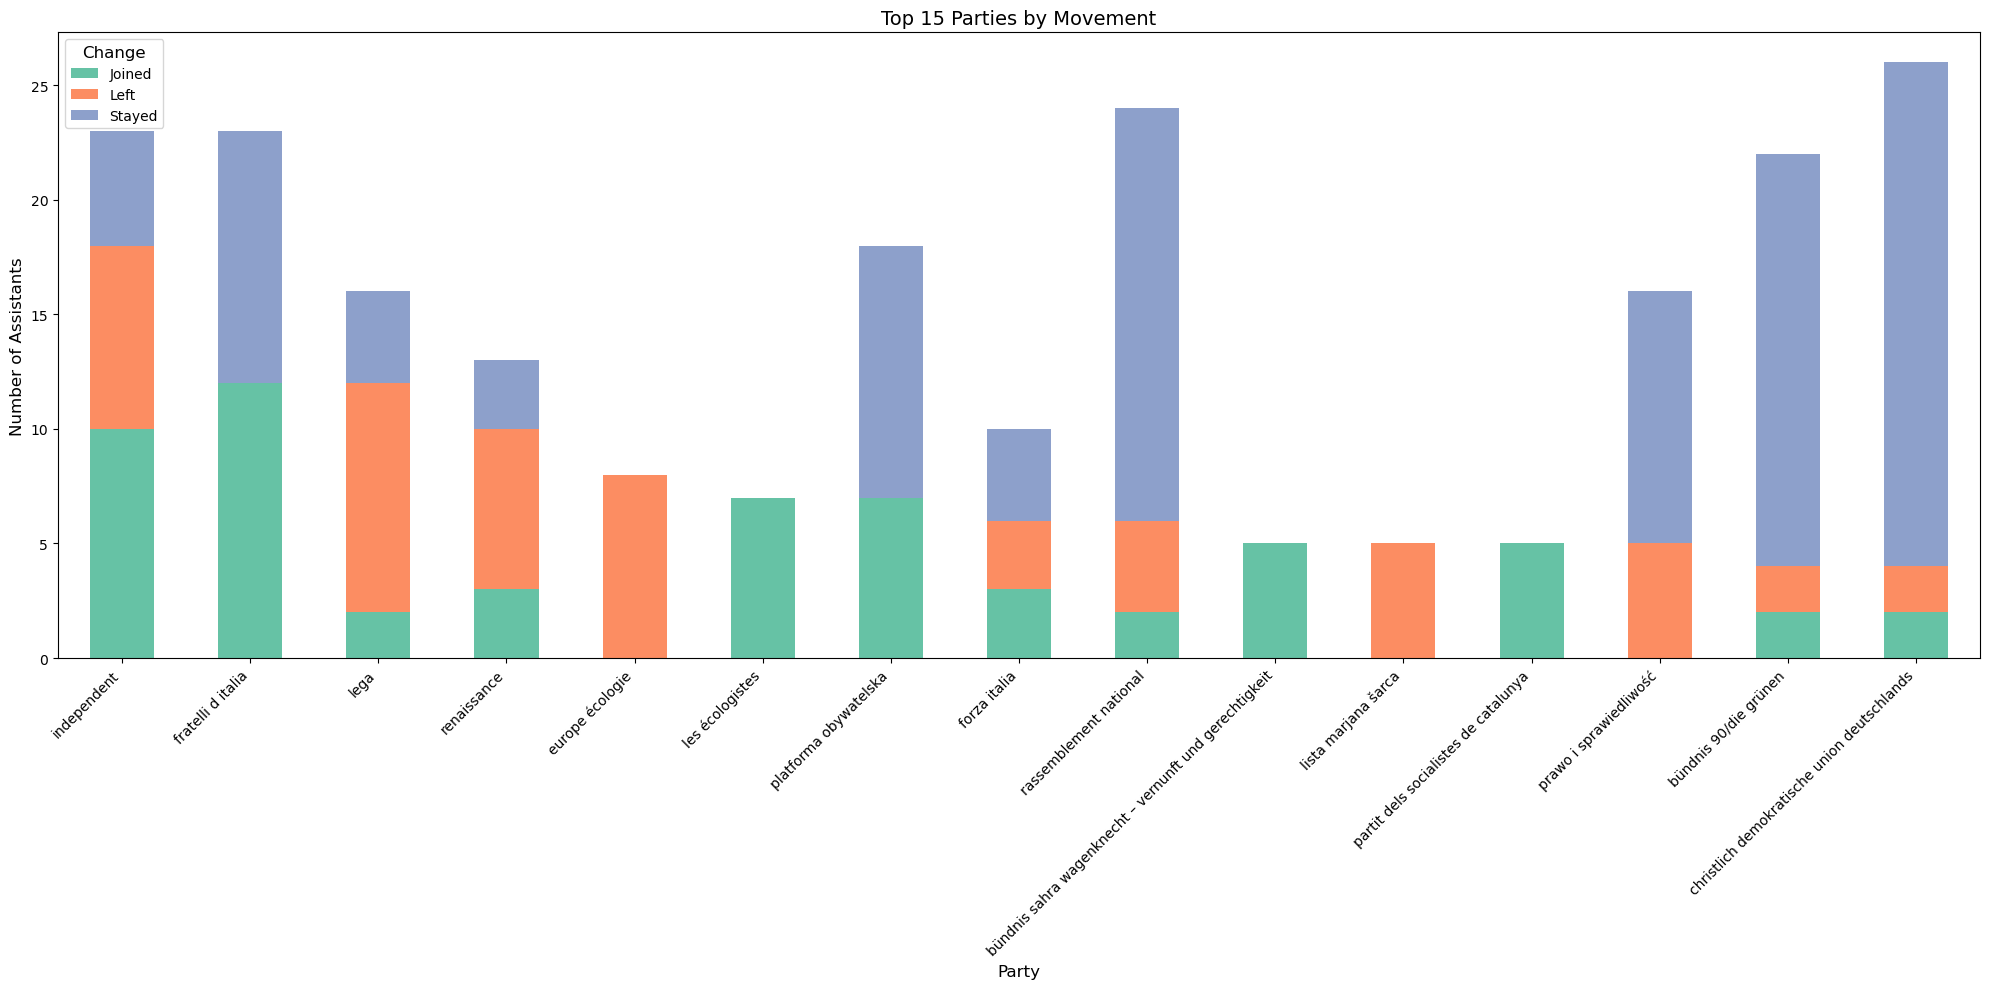

In [261]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Function to normalize party names (lowercase, strip spaces, and handle special characters)
def normalize_party_names(party_set):
    normalized_set = set()
    for party in party_set:
        # Remove unwanted characters like extra apostrophes or spaces
        party_normalized = party.strip().lower()  # Convert to lowercase and strip spaces
        party_normalized = re.sub(r"[’']+", " ", party_normalized)  # Replace apostrophes with space (e.g., "Fratelli d' Italia" -> "Fratelli d Italia")
        party_normalized = re.sub(r"\s+", " ", party_normalized)  # Replace multiple spaces with a single space
        normalized_set.add(party_normalized)
    return normalized_set

# Function to classify party changes
def classify_party_changes(row):
    # Normalize party names for term_9 and term_10
    term_9 = normalize_party_names(row['term_9'])
    term_10 = normalize_party_names(row['term_10'])
    
    stayed = term_9 & term_10  # Intersection of sets (stayed)
    left = term_9 - term_10    # Parties in term_9 but not in term_10 (left)
    joined = term_10 - term_9  # Parties in term_10 but not in term_9 (joined)
    
    # Overall movement status
    if stayed == term_9 == term_10:
        movement_status = "Stayed"
    elif len(left) == 0 and len(joined) > 0:
        movement_status = "Expanded"
    elif len(left) > 0 and len(joined) == 0:
        movement_status = "Reduced"
    else:
        movement_status = "Moved"

    # Create a record for each faction
    party_changes = []
    for party in term_9 | term_10:
        if party in stayed:
            party_changes.append((party, "Stayed"))
        if party in left:
            party_changes.append((party, "Left"))
        if party in joined:
            party_changes.append((party, "Joined"))

    return pd.DataFrame(party_changes, columns=["Party", "Change"]), movement_status

# Apply classification function
all_party_changes = []
movement_statuses = []
for _, row in party_merged_data.iterrows():
    party_changes, movement_status = classify_party_changes(row)
    all_party_changes.append(party_changes)
    movement_statuses.append(movement_status)

# Combine faction changes into one DataFrame
party_changes_df = pd.concat(all_party_changes).reset_index(drop=True)

# Add movement statuses to original DataFrame
party_merged_data['Movement Status'] = movement_statuses

# Count categories per faction, ensuring all possible categories are included
party_summary = party_changes_df.groupby(['Party', 'Change']).size().unstack(fill_value=0)

# Calculate the fluctuation (Joined + Left) for each party
party_summary['Fluctuation'] = party_summary.get('Joined', 0) + party_summary.get('Left', 0)

# Get the top 15 parties with the highest fluctuation
top_15_parties = party_summary.nlargest(15, 'Fluctuation')

# Print the summary of the top 15 parties
print(top_15_parties)

# Set a custom color palette for the chart
custom_palette = sns.color_palette('Set2')  # Aesthetic and distinct colors from seaborn

# Plot stacked bar chart with the custom palette for the top 15 parties
top_15_parties.drop('Fluctuation', axis=1).plot(kind='bar', stacked=True, figsize=(20, 10), color=custom_palette)
plt.title("Top 15 Parties by Movement", fontsize=14)
plt.xlabel("Party", fontsize=12)
plt.ylabel("Number of Assistants", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Change", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

In [266]:
import pandas as pd

# Step 1: Filter and group data for Term 9 and Term 10
term_9_data = filtered_apas_both_terms[filtered_apas_both_terms['term'] == 9]
term_9_grouped_party = term_9_data.groupby('assistant_name')['mep_party'].apply(
    lambda x: set(x)
).reset_index(name='term_9')

term_10_data = filtered_apas_both_terms[filtered_apas_both_terms['term'] == 10]
term_10_grouped_party = term_10_data.groupby('assistant_name')['mep_party'].apply(
    lambda x: set(x)
).reset_index(name='term_10')

# Step 2: Merge the two datasets based on 'assistant_name'
party_merged_data = pd.merge(term_9_grouped_party, term_10_grouped_party, on='assistant_name', how='outer')

# Step 3: Define categorization function for party movement
def categorize_party(term_9_parties, term_10_parties):
    term_9_set = term_9_parties if isinstance(term_9_parties, set) else set()
    term_10_set = term_10_parties if isinstance(term_10_parties, set) else set()

    stayed = term_9_set & term_10_set  # Common parties
    added = term_10_set - term_9_set   # New parties in Term 10
    dropped = term_9_set - term_10_set # Dropped parties from Term 9

    if not term_9_set and term_10_set:
        return "Only Term 10"  # Completely new assistant in Term 10
    if term_9_set and not term_10_set:
        return "Only Term 9"  # Assistant dropped out after Term 9
    if stayed == term_9_set == term_10_set:
        return "Same Party"  # No change
    if stayed and added and not dropped:
        return "Added New Party"  # Retained old and added new parties
    if stayed and dropped and not added:
        return "Dropped Party"  # Retained some but dropped others
    if stayed and added and dropped:
        return "Mixed Changes"  # Retained some, added new, and dropped some
    if not stayed and added and dropped:
        return "Completely Changed Party"  # No overlap; completely different set of parties
    if not stayed and added:
        return "New Party"  # Only new parties in Term 10 (no overlap with Term 9)

    return "Unexpected Case"  # Catch-all for debugging

# Apply categorization for each assistant
party_merged_data['party_movement'] = party_merged_data.apply(
    lambda row: categorize_party(row['term_9'], row['term_10']), axis=1
)

# Step 4: Create a summary of movement categories
party_movement_summary = party_merged_data['party_movement'].value_counts()

# Print the summary
print("\nParty Movement Summary:")
print(party_movement_summary)

# Step 5: Optionally Print Assistants in Each Category
for category in party_movement_summary.index:
    print(f"\nAssistants in '{category}':")
    print(party_merged_data[party_merged_data['party_movement'] == category][['assistant_name', 'term_9', 'term_10']])


Party Movement Summary:
party_movement
Same Party                  438
Completely Changed Party    139
Added New Party              14
Dropped Party                 7
Mixed Changes                 2
Name: count, dtype: int64

Assistants in 'Same Party':
                    assistant_name  \
0    AMANDA ELISABET ANNIE ARLEKLO   
1                     Abel PASZTOR   
4          Adriana-Roxana ANDRONIC   
5                   Agnes POPOVICS   
6                    Agnieszka BAK   
..                             ...   
593      Yves Jean Pierre HOFFMANN   
595                Zaritsa DINKOVA   
597               Zsuzsanna PATAKI   
598                Zuzana LAHOUSSE   
599                    Özlem DENIZ   

                                                term_9  \
0                              {Miljöpartiet de gröna}   
1    {Fidesz-Magyar Polgári Szövetség-Kereszténydem...   
4                          {Partidul Naţional Liberal}   
5                              {Demokratikus Koalíció}  

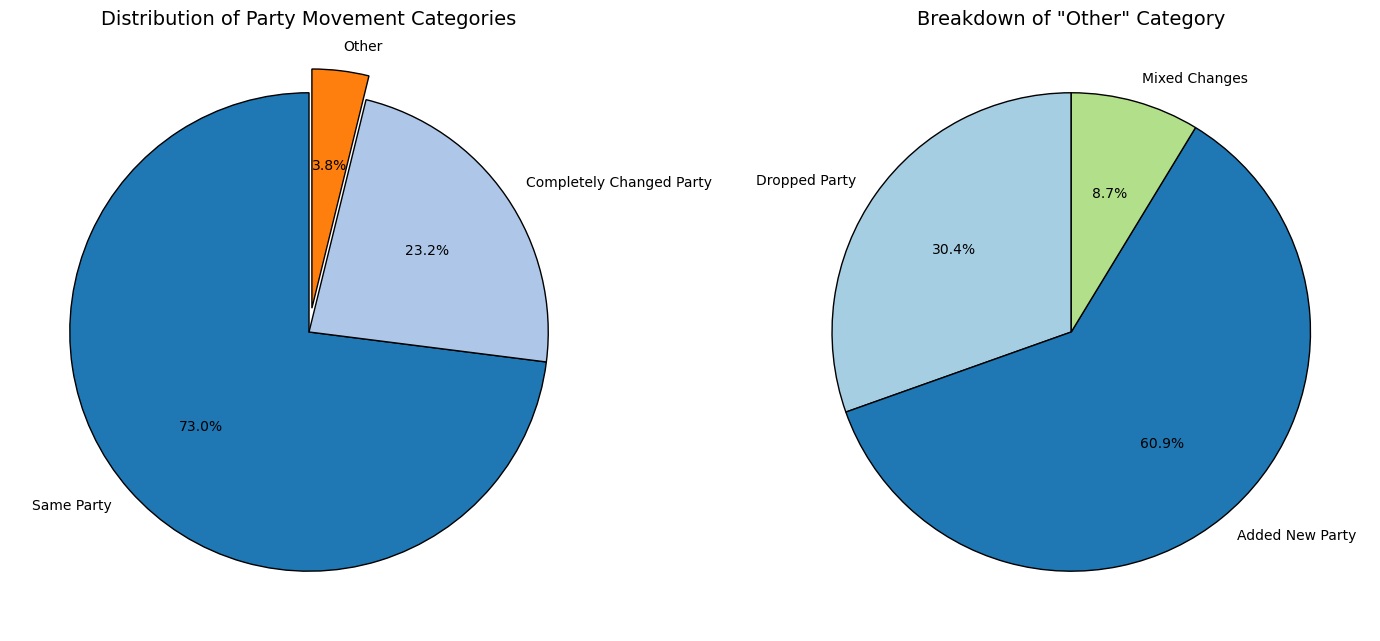

In [280]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your party movement summary looks like this:
party_movement_summary = party_merged_data['party_movement'].value_counts()

# Step 1: Group the "Dropped Party", "Added New Party", and "Mixed Changes" into an "Other" category
other_categories = ['Dropped Party', 'Added New Party', 'Mixed Changes']
other_value = party_movement_summary[other_categories].sum()
party_movement_summary_filtered = party_movement_summary.drop(other_categories)
party_movement_summary_filtered["Other"] = other_value

# Step 2: Create two pie charts: one for the main distribution and one for the "Other" category breakdown
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Main Pie Chart (with "Other" category)
ax1.pie(party_movement_summary_filtered, labels=party_movement_summary_filtered.index, autopct='%1.1f%%',
        startangle=90, colors=plt.cm.tab20.colors, wedgeprops={'edgecolor': 'black'},
        explode=[0.1 if label == 'Other' else 0 for label in party_movement_summary_filtered.index])

# Title for the main pie chart
ax1.set_title('Distribution of Party Movement Categories', fontsize=14)

# Secondary Pie Chart for the "Other" category breakdown
# Extract the values of the "Other" category and show the individual components
other_details = party_movement_summary[other_categories]

# Plot the secondary pie chart showing the breakdown of "Other"
ax2.pie(other_details, labels=other_details.index, autopct='%1.1f%%', startangle=90, 
        colors=plt.cm.Paired.colors, wedgeprops={'edgecolor': 'black'})

# Title for the secondary pie chart
ax2.set_title('Breakdown of "Other" Category', fontsize=14)

# Step 3: Add a connecting line from the "Other" slice in the main chart to the secondary pie chart
# Add an annotation with an arrow pointing from the "Other" slice in ax1 to ax2
#ax1.annotate('', xy=(1, 0.8), xytext=(1.6, 0), arrowprops=dict(arrowstyle="->", lw=2, color='black'))

# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()

## 4.3 By country

In [228]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter and explode data for Term 9 and Term 10
term_9_data = filtered_apas_both_terms[filtered_apas_both_terms['term'] == 9]
term_9_grouped_country = term_9_data.groupby('assistant_name')['country'].apply(
    lambda x: set(x)
).reset_index(name='term_9')

term_10_data = filtered_apas_both_terms[filtered_apas_both_terms['term'] == 10]
term_10_grouped_country = term_10_data.groupby('assistant_name')['country'].apply(
    lambda x: set(x)
).reset_index(name='term_10')

# Step 2: Merge the two datasets based on 'assistant_name'
country_merged_data = pd.merge(term_9_grouped_country, term_10_grouped_country, on='assistant_name', how='outer')
print(country_merged_data)

                    assistant_name               term_9     term_10
0    AMANDA ELISABET ANNIE ARLEKLO             {Sweden}    {Sweden}
1                     Abel PASZTOR            {Hungary}   {Hungary}
2                    Adam MOUCHTAR  {Germany, Slovenia}  {Bulgaria}
3                  Adrian NAUGHTON            {Ireland}   {Germany}
4          Adriana-Roxana ANDRONIC            {Romania}   {Romania}
..                             ...                  ...         ...
595                Zaritsa DINKOVA           {Bulgaria}  {Bulgaria}
596                  Zoltán PANCZA            {Hungary}   {Hungary}
597               Zsuzsanna PATAKI            {Romania}   {Romania}
598                Zuzana LAHOUSSE            {Czechia}   {Czechia}
599                    Özlem DENIZ            {Germany}   {Germany}

[600 rows x 3 columns]


In [232]:
# Step 1: Explode term_9 and term_10 into separate rows
term_9_exploded = country_merged_data[['assistant_name', 'term_9']].explode('term_9')
term_9_exploded.rename(columns={'term_9': 'Country'}, inplace=True)
term_9_exploded['Term'] = 9

term_10_exploded = country_merged_data[['assistant_name', 'term_10']].explode('term_10')
term_10_exploded.rename(columns={'term_10': 'Country'}, inplace=True)
term_10_exploded['Term'] = 10

# Step 2: Combine exploded data for both terms
exploded_data = pd.concat([term_9_exploded, term_10_exploded], ignore_index=True)

# Step 3: Count assistants associated with each faction
country_counts = exploded_data.groupby(['Country', 'Term']).size().reset_index(name='Assistant Count')

# Step 4: Display the result
print(country_counts)

           Country  Term  Assistant Count
0          Austria     9               11
1          Austria    10               10
2          Belgium     9               18
3          Belgium    10               23
4         Bulgaria     9               14
5         Bulgaria    10               15
6          Croatia     9                4
7          Croatia    10                4
8           Cyprus     9                8
9           Cyprus    10                5
10         Czechia     9               17
11         Czechia    10               19
12         Denmark     9                2
13         Denmark    10                2
14         Estonia     9               12
15         Estonia    10               12
16         Finland     9                8
17         Finland    10               10
18          France     9               73
19          France    10               67
20         Germany     9               98
21         Germany    10              101
22          Greece     9          

Change          Joined  Left  Stayed
Country                             
Austria              2     3       8
Belgium              5     0      18
Bulgaria             1     0      14
Croatia              0     0       4
Cyprus               0     3       5
Czechia              4     2      15
Denmark              0     0       2
Estonia              0     0      12
Finland              2     0       8
France               1     7      66
Germany              8     5      93
Greece               2     0      14
Hungary              0     2      22
Ireland              0     4       7
Italy                2     1      72
Latvia               0     0       7
Lithuania            1     0      10
Luxembourg           1     0       6
Malta                1     0       4
Netherlands          6     1      20
Poland               1     1      42
Portugal             1     1      21
Romania              1     2      25
Slovakia             2     0       8
Slovenia             0     2       9
S

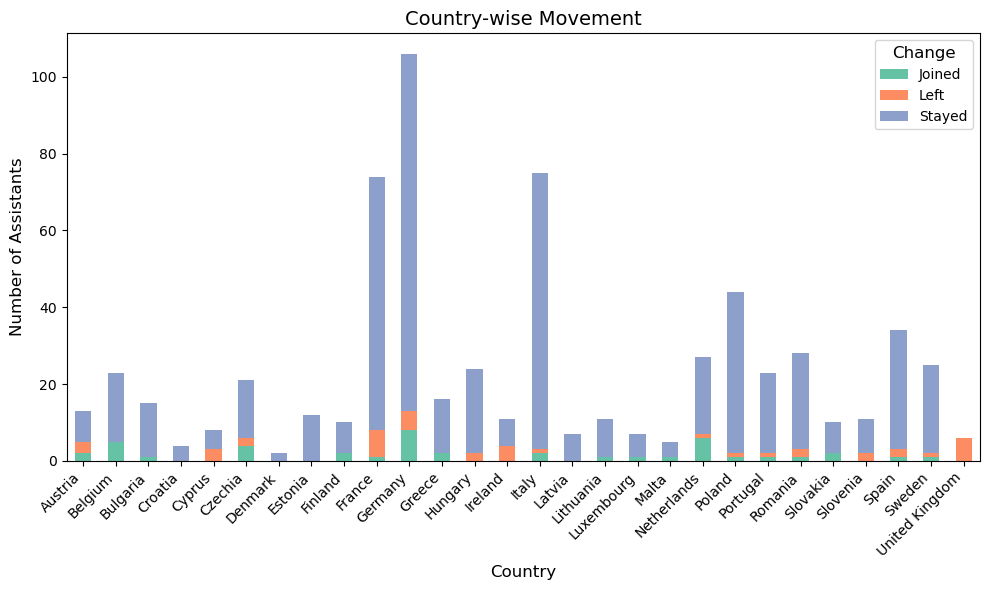

In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to classify party changes
def classify_party_changes(row):
    term_9 = row['term_9']
    term_10 = row['term_10']
    
    stayed = term_9 & term_10  # Intersection of sets
    left = term_9 - term_10    # Parties in term_9 but not in term_10
    joined = term_10 - term_9  # Parties in term_10 but not in term_9
    
    # Overall movement status
    if stayed == term_9 == term_10:
        movement_status = "Stayed"
    elif len(left) == 0 and len(joined) > 0:
        movement_status = "Expanded"
    elif len(left) > 0 and len(joined) == 0:
        movement_status = "Reduced"
    else:
        movement_status = "Moved"

    # Create a record for each faction
    country_changes = []
    for country in term_9 | term_10:
        if country in stayed:
            country_changes.append((country, "Stayed"))
        if country in left:
            country_changes.append((country, "Left"))
        if country in joined:
            country_changes.append((country, "Joined"))

    return pd.DataFrame(country_changes, columns=["Country", "Change"]), movement_status

# Apply classification function
all_country_changes = []
movement_statuses = []
for _, row in country_merged_data.iterrows():
    country_changes, movement_status = classify_party_changes(row)
    all_country_changes.append(country_changes)
    movement_statuses.append(movement_status)

# Combine faction changes into one DataFrame
country_changes_df = pd.concat(all_country_changes).reset_index(drop=True)

# Add movement statuses to original DataFrame
country_merged_data['Movement Status'] = movement_statuses

# Count categories per faction, ensuring all possible categories are included
country_summary = country_changes_df.groupby(['Country', 'Change']).size().unstack(fill_value=0)

# Print the summary
print(country_summary)

# Set a custom color palette for the chart
custom_palette = sns.color_palette('Set2')  # Aesthetic and distinct colors from seaborn

# Plot stacked bar chart with the custom palette
country_summary.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_palette)
plt.title("Country-wise Movement", fontsize=14)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of Assistants", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Change", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

# 5. Most APA Movement

In [235]:
import pandas as pd

df = filtered_apas_both_terms

# Step 1: Group by MEP, assistant_type, and term, then count unique assistants
assistant_changes = (
    df.groupby(['mep_name', 'assistant_type', 'term'])['assistant_name']
    .nunique()
    .reset_index(name='unique_assistants')
)

# Step 2: Analyze changes by MEP and assistant type
# Count the number of unique assistants per MEP and assistant type across terms
assistant_change_summary = (
    assistant_changes.groupby(['mep_name', 'assistant_type'])['unique_assistants']
    .sum()
    .reset_index(name='total_assistant_changes')
)

# Step 3: Find the MEPs with the most assistant changes
# Sort the results by total_assistant_changes in descending order
most_changes = assistant_change_summary.sort_values(
    by='total_assistant_changes', ascending=False
)

# Split the analysis by assistant type for detailed breakdown
accredited_changes = most_changes[most_changes['assistant_type'] == 'accredited']
grouping_changes = most_changes[most_changes['assistant_type'] == 'accredited_grouping']

# Output results
print("Top MEPs with the most assistant changes (Overall):")
print(most_changes.head(10))

print("\nTop MEPs with the most accredited assistant changes:")
print(accredited_changes.head(10))

print("\nTop MEPs with the most grouping assistant changes:")
print(grouping_changes.head(10))

Top MEPs with the most assistant changes (Overall):
                     mep_name       assistant_type  total_assistant_changes
197               César LUENA  accredited_grouping                       47
449           Jonás FERNÁNDEZ  accredited_grouping                       40
656        Nacho SÁNCHEZ AMOR  accredited_grouping                       24
667  Nicolás GONZÁLEZ CASARES  accredited_grouping                       24
382       Iratxe GARCÍA PÉREZ  accredited_grouping                       24
249      Elena SANCHO MURILLO  accredited_grouping                       24
32          Alicia HOMS GINEL  accredited_grouping                       24
769       Rosa SERRANO SIERRA  accredited_grouping                       24
374              Idoia MENDIA  accredited_grouping                       24
518               Lina GÁLVEZ  accredited_grouping                       24

Top MEPs with the most accredited assistant changes:
                 mep_name assistant_type  total_assistant_